## import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import traceback
import semopy

import networkx as nx
from graphviz import Digraph
from IPython.display import display, Image

from causalnex.structure.pytorch import from_pandas
from causalnex.structure import StructureModel
from causalnex.network import BayesianNetwork
from causalnex.evaluation import classification_report, roc_auc
from causalnex.inference import InferenceEngine

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, MinMaxScaler

import optuna

from SEM import run_SEM, detect_subgraph, make_mod, show_sem_grapgh
from IPython.display import Image

import warnings
warnings.simplefilter('ignore')
import os
import sys
import pickle

/Users/bigsum/opt/miniforge3/envs/Baysian/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 関数読み込み

### ベイズ最適化関数, スコアリング関数, 構造学習関数, 連番生成関数, ネットワーク可視化関数

In [2]:
# # cuda割り当て
# import torch
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

# ベイズ最適化関数
def objective_variable_degree(data):
    # 目的関数
    def objective(trial):
        # Optunaでチューニングするハイパーパラメータ
        threshold = trial.suggest_float('threshold', 0.2, 0.4)
        lasso_beta = trial.suggest_float('lasso_beta', 1e-2, 1e-1, log=True)  # ログスケールでlassoの値を探索
        ridge_beta = trial.suggest_float('ridge_beta', 1e-2, 1e-1, log=True)  # リッジ正則化の係数を探索

        # StructureModelのインスタンスを作成
        sm = StructureModel()

        # NOTEARSアルゴリズムを用いて構造学習を実施
        # ここでfrom_pandasのパラメータをOptunaのtrialを通してチューニング
        sm = from_pandas(data, 
                        lasso_beta=lasso_beta,
                        ridge_beta=ridge_beta,
                        )
        
        #from_pandasで学習した後に閾値を探索する
        sm.remove_edges_below_threshold(threshold)
        #構造をDAG構造に修正
        sm.threshold_till_dag()
        sm_l = sm.get_largest_subgraph()

        # view_graph_from_sm(sm, "a", False, True)
        #smを接続行列に変換
        connection_matrix = pd.DataFrame(sm_to_dag_matrix(sm_l))
        #run_SEMを実行
        try:
            sm_SEM = run_SEM(data, connection_matrix, threshold)
            # 学習された構造のスコアを計算（スコアリング方法はプロジェクトにより異なる）
            score = sm_SEM[1]
            rmsea = score[0]
            # aic = score[3]

            # rmseaが0.0の場合も2.0に設定
            if rmsea == 0.0:
                rmsea = 2.0
                
        except Exception as e:
            #SEM学習時にエラーを吐かれた場合は、rmsea値を2.0としエラー回避する。
            rmsea = 2.0
            # aic = 1000
        
        # 結果出力（パス図）
        pass_graph = semopy.semplot(sm_SEM[0], "semopy.png",
                                engine="dot",        # 階層的なグラフを生成するエンジン(デフォルト)
                                plot_covs=True,      # Ture: 共分散がプロット
                                std_ests=True)       # Ture: 標準化された推定値をプロット
        
        Image("semopy.png")
        trial.set_user_attr('best_sm', sm)
        return rmsea
    return objective

# 構造学習用関数
def Learning(best_params, data):
    # 最適な閾値で構造学習を実施
    best_sm = from_pandas(data,
                        lasso_beta=best_params['lasso_beta'],
                        ridge_beta=best_params['ridge_beta'],
                        )

    best_sm.remove_edges_below_threshold(best_params['threshold'])
    best_sm.threshold_till_dag()
    view_graph_from_sm(best_sm, "a", False, True)

    best_sm = pd.DataFrame(sm_to_dag_matrix(best_sm))
    sm_SEM = run_SEM(data, best_sm, best_params['threshold'])
    model = sm_SEM[0]
    rmsea = sm_SEM[1]
    value = sm_SEM[2]
    
    return model, rmsea, value

# 連番生成関数
def create_filename(base_name, directory='.', extension='.png'):
    counter = 1
    while True:
        file_name = f"{base_name}_{counter}{extension}"
        full_path = os.path.join(directory, file_name)
        if not os.path.exists(full_path):
            return full_path
        counter += 1

def sm_to_dag_matrix(sm: StructureModel):
    """smの因果グラフを接続行列に変換する

    Args:
        sm (StructureModel): smの因果グラフ

    Returns:
        np.array: 接続行列
    """
    # 因果グラフのノード数
    nodes = sm.nodes
    n = len(nodes)

    # ノード名をインデックスに変換する辞書
    node_index = {node: i for i, node in enumerate(nodes)}

    # 接続行列の初期化
    connection_matrix = np.zeros((n, n))

    # 接続行列の作成
    for from_node, to_node in sm.edges:
        connection_matrix[node_index[from_node], node_index[to_node]] = 1
        
    # データフレームに変換して、特徴量名の設定する
    feature_names = list(node_index.keys())
    df_connection_matrix = pd.DataFrame(connection_matrix, columns=feature_names, index=feature_names)

    return df_connection_matrix

def view_graph_from_sm(sm: StructureModel, filename, save=True, show=True):
    """因果グラフをPNG形式で保存し、Jupyter Notebook上で表示する

    Args:
        sm (StructureModel): smの因果グラフ
        filename (str): 保存するファイル名（png形式）
    """
    # GraphvizのDigraphオブジェクトの作成
    dot = Digraph()

    # StructureModelオブジェクトからグラフを定義（ノードとエッジの追加）
    for node in sm.nodes:
        dot.node(node)
    for from_node, to_node in sm.edges:
        dot.edge(from_node, to_node)
        
    # グラフをPNG形式で保存
    if save:
        if filename.endswith('.png'):
            filename = filename[:-4]
        dot.render(filename, format='png', cleanup=True)

    # グラフをPNG形式で一時ファイルに保存し、Jupyter Notebook上で表示
    if show:
        png_bytes = dot.pipe(format='png')
        display(Image(png_bytes))

def select_edges_with_confidence_interval(p_value, alpha=0.05):
    # SEMを使って得られたエッジのp値を取得する処理が必要です。
    # この例では、dataとしてp値が格納された配列が与えられると仮定します。
    # 以下のコードは仮想的なもので、実際のp値の取得方法に合わせて修正してください。
    
    # 信頼区間内のエッジを取得
    significant_edges = np.where(p_value < alpha, 1, 0)

    return significant_edges

## データ読み込みから前処理

### データ読み込み

In [3]:
path = '../data/qPCR(相対値)_対数増殖期.csv'

df = pd.read_csv(path, header=0)
df = df.dropna()
df = df.drop(['gene', '培養時間'], axis=1)
df = df.reset_index(drop=True)
print(df.shape)
df

(116, 33)


glk       agp      yihX       pgm      ptsG          malx  \
0    3.840000e-06  0.000008  0.000008  0.000008  0.000016  9.670000e-07   
1    7.780000e-06  0.000008  0.000004  0.000008  0.000016  4.830000e-07   
2    1.550000e-05  0.000015  0.000008  0.000008  0.000031  1.940000e-06   
3    3.830000e-06  0.000015  0.000004  0.000008  0.000016  9.570000e-07   
4    7.660000e-06  0.000031  0.000031  0.000015  0.000063  1.930000e-06   
..            ...       ...       ...       ...       ...           ...   
111  6.100000e-05  0.000030  0.000062  0.000061  0.000125  7.780000e-06   
112  9.410000e-07  0.000004  0.000002  0.000008  0.000008  9.710000e-07   
113  2.070000e-05  0.000019  0.000025  0.000012  0.000028  2.490000e-06   
114  7.670000e-06  0.000031  0.000016  0.000031  0.000032  3.970000e-06   
115  5.180000e-05  0.000048  0.000054  0.000040  0.000055  5.490000e-06   

          crr          galM          yihR      yeaD  ...      tpiA      gapA  \
0    0.000062  7.600000e-06  2.400000e-07  0.000015  ...  0.000015  0.000122   
1    0.000062  3.820000e-06  6.040000e-08  0.000016  ...  0.000016  0.000123   
2    0.000124  7.680000e-06  6.050000e-08  0.000031  ...  0.000031  0.000245   
3    0.000062  7.610000e-06  2.400000e-07  0.000015  ...  0.000015  0.000122   
4    0.000121  3.050000e-05  9.660000e-07  0.000063  ...  0.000062  0.000246   
..        ...           ...           ...       ...  ...       ...       ...   
111  0.000247  3.060000e-05  1.930000e-06  0.000015  ...  0.000031  0.000245   
112  0.000031  1.190000e-07  2.430000e-07  0.000004  ...  0.000004  0.000031   
113  0.000061  1.430000e-05  5.470000e-07  0.000004  ...  0.000009  0.000058   
114  0.000124  9.600000e-07  1.000000e-06  0.000008  ...  0.000016  0.000123   
115  0.000148  2.740000e-05  5.800000e-07  0.000009  ...  0.000018  0.000090   

          pgk      gpmA          ytjc          gpmM       eno      pykF  \
0    0.000061  0.000061  3.850000e-06  1.550000e-05  0.000122  0.000061   
1    0.000031  0.000031  3.870000e-06  1.550000e-05  0.000062  0.000062   
2    0.000124  0.000061  3.860000e-06  3.090000e-05  0.000246  0.000124   
3    0.000062  0.000031  3.850000e-06  7.850000e-06  0.000061  0.000031   
4    0.000250  0.000122  7.740000e-06  1.550000e-05  0.000490  0.000122   
..        ...       ...           ...           ...       ...       ...   
111  0.000122  0.000245  3.060000e-05  3.150000e-05  0.000121  0.000122   
112  0.000008  0.000031  9.540000e-07  4.840000e-07  0.000004  0.000008   
113  0.000046  0.000075  1.550000e-05  1.910000e-06  0.000045  0.000043   
114  0.000030  0.000124  1.940000e-06  3.850000e-06  0.000016  0.000062   
115  0.000092  0.000126  2.210000e-05  4.730000e-06  0.000356  0.000096   

             pykA      ppsA  
0    3.080000e-05  0.000031  
1    3.060000e-05  0.000015  
2    6.160000e-05  0.000031  
3    3.070000e-05  0.000062  
4    6.140000e-05  0.000122  
..            ...       ...  
111  6.070000e-05  0.000061  
112  4.780000e-07  0.000008  
113  1.790000e-05  0.000026  
114  1.920000e-06  0.000031  
115  3.460000e-05  0.000048  

[116 rows x 33 columns]

### 標準化

- データの最大値，最小値が決まっていない
- 一般的に用いられる

- StadardScaler():平均値0、分散値1に標準化
- MinMaxScaler(): min0~max1の範囲で分布

In [4]:
# 標準化
# scaler = StandardScaler()

scaler = MinMaxScaler()
normalized_data_array = scaler.fit_transform(df)
# DataFrame型に変換
normalized_df = pd.DataFrame(normalized_data_array, columns=df.columns)

normalized_df.head()

glk       agp      yihX       pgm      ptsG      malx       crr  \
0  0.058242  0.057658  0.045983  0.120496  0.031370  0.095349  0.138276   
1  0.121931  0.057739  0.015328  0.122715  0.031783  0.032647  0.140077   
2  0.246723  0.120290  0.046382  0.121447  0.096586  0.221402  0.421124   
3  0.058080  0.119483  0.015088  0.120813  0.031370  0.094054  0.138276   
4  0.119991  0.243618  0.233425  0.240796  0.225367  0.220106  0.406396   

       galM      yihR      yeaD  ...      tpiA      gapA       pgk      gpmA  \
0  0.120893  0.011484  0.190635  ...  0.047280  0.194860  0.117203  0.065103   
1  0.059808  0.000000  0.195652  ...  0.048096  0.198326  0.058872  0.000000   
2  0.122186  0.000006  0.453177  ...  0.110972  0.457979  0.239447  0.065748   
3  0.121055  0.011484  0.190635  ...  0.047280  0.195344  0.118550  0.000000   
4  0.490958  0.057904  0.979933  ...  0.236725  0.460621  0.480151  0.196150   

       ytjc      gpmM       eno      pykF      pykA      ppsA  
0  0.094986  0.473948  0.242715  0.222566  0.486604  0.093456  
1  0.095640  0.473948  0.121783  0.225888  0.483395  0.031314  
2  0.095313  0.944948  0.488931  0.482015  0.980748  0.094675  
3  0.094986  0.239977  0.120784  0.095528  0.484999  0.219770  
4  0.222310  0.473948  0.977227  0.476635  0.977539  0.462882  

[5 rows x 33 columns]

## from_pandas構造学習

### パラメータ

**lasso_beta(Lasso推定量)**: 過学習を防いだり，モデルを単純にするために不要なパラメータを削っていると大きくなる．
- Lassoは不要な係数を0にすることができるので変数選択に有効 -> 変数選択をするので多重共線性にも有効?
- 過剰な係数を縮小させるので過学習の防止
- 高次元データ(遺伝子データなど)に効果的な特徴量選択とモデルの単純化を行うことができる．

**注意点**
- ラムダの選択(パラメータチューニング)を間違えるとモデルの性能に大きく影響が出る．

**ridge_beta(Ridge推定量)**: 大きな特徴量にペナルティーを与えて重みを調整し，過学習を回避している場合に大きくなる．
- 多重共線性(変数間に強い相関)がある場合，安定したパラメータ推定を行うので有効
    - 損失関数に係数の二乗の和に基づくL2正則化項を加えるので，係数の絶対値の合計が大きくなりすぎることを防ぐ．
    - 正則化によりパラメータが過大になることを抑え，特徴間の相関が強い場合でもパラメータが不安定になるのを防ぐ．
    - 上記2点の効能により，モデルが安定しやすくなる．
- 次元の呪い(特徴量の過多)がある場合に，モデルの一般化能力を向上させるのに向いている
- 多重共線性の問題を緩和し，過学習を回避することでモデルの未知のデータに対する一般化能力を高め，より堅牢で信頼性の高い予測モデルとなる．

**L1とL2のユースケース**
- 特徴量が少ない or 解釈しやすい(特徴量が少ない)モデルが欲しい場合はラッソ回帰
- 特徴量の多いデータの場合はリッジ回帰
- 計算コストは上がるが，どっちも適度に使用することで予測性能の高いモデルを作ることができる．

### 用語

**次元の呪い**: データの次元（特徴の数）が増加するにつれ，統計・機械学習モデルの性能に悪影響を及ぼす一連の問題を指す．
- 単純に計算コストの増加
- サンプル数問題: 高次元データを扱うためのサンプル数が足りない場合，過学習を引き起こす
- データの希薄化
- モデルの解釈性の低下

**多重共線性**: 多重共線性は，予測モデルにおいて二つ以上の予測変数（特徴）が高い相関を持つ状況を指す．
- 共線性が存在すると，線形回帰モデルの係数の推定が不安定になり，過剰に大きな値をとることがある．これは，モデルが訓練データのランダムなノイズに過剰に適合し，未知のデータに対する予測性能が低下する原因となる．

### パラメータ探索

[I 2024-04-23 16:20:37,461] A new study created in memory with name: no-name-df25cbda-1168-4690-a313-6bea3fa2b739
[I 2024-04-23 16:20:40,712] Trial 0 finished with value: 0.12521 and parameters: {'threshold': 0.21254894703499103, 'lasso_beta': 0.021615804956969298, 'ridge_beta': 0.09181182589157091}. Best is trial 0 with value: 0.12521.
[I 2024-04-23 16:20:44,090] Trial 1 finished with value: 0.13107 and parameters: {'threshold': 0.28658209711342963, 'lasso_beta': 0.034891314125498896, 'ridge_beta': 0.0707874923509878}. Best is trial 0 with value: 0.12521.
[I 2024-04-23 16:20:48,210] Trial 2 finished with value: 0.12324 and parameters: {'threshold': 0.23604451681742164, 'lasso_beta': 0.08292109826162014, 'ridge_beta': 0.048451481343309885}. Best is trial 2 with value: 0.12324.
[I 2024-04-23 16:20:51,769] Trial 3 finished with value: 0.12945 and parameters: {'threshold': 0.214455847021051, 'lasso_beta': 0.031396723599335506, 'ridge_beta': 0.021745402031474056}. Best is trial 2 with valu

{'threshold': 0.20528443028703294, 'lasso_beta': 0.01141697595295701, 'ridge_beta': 0.010102255330630559}
StructureModel with 33 nodes and 126 edges


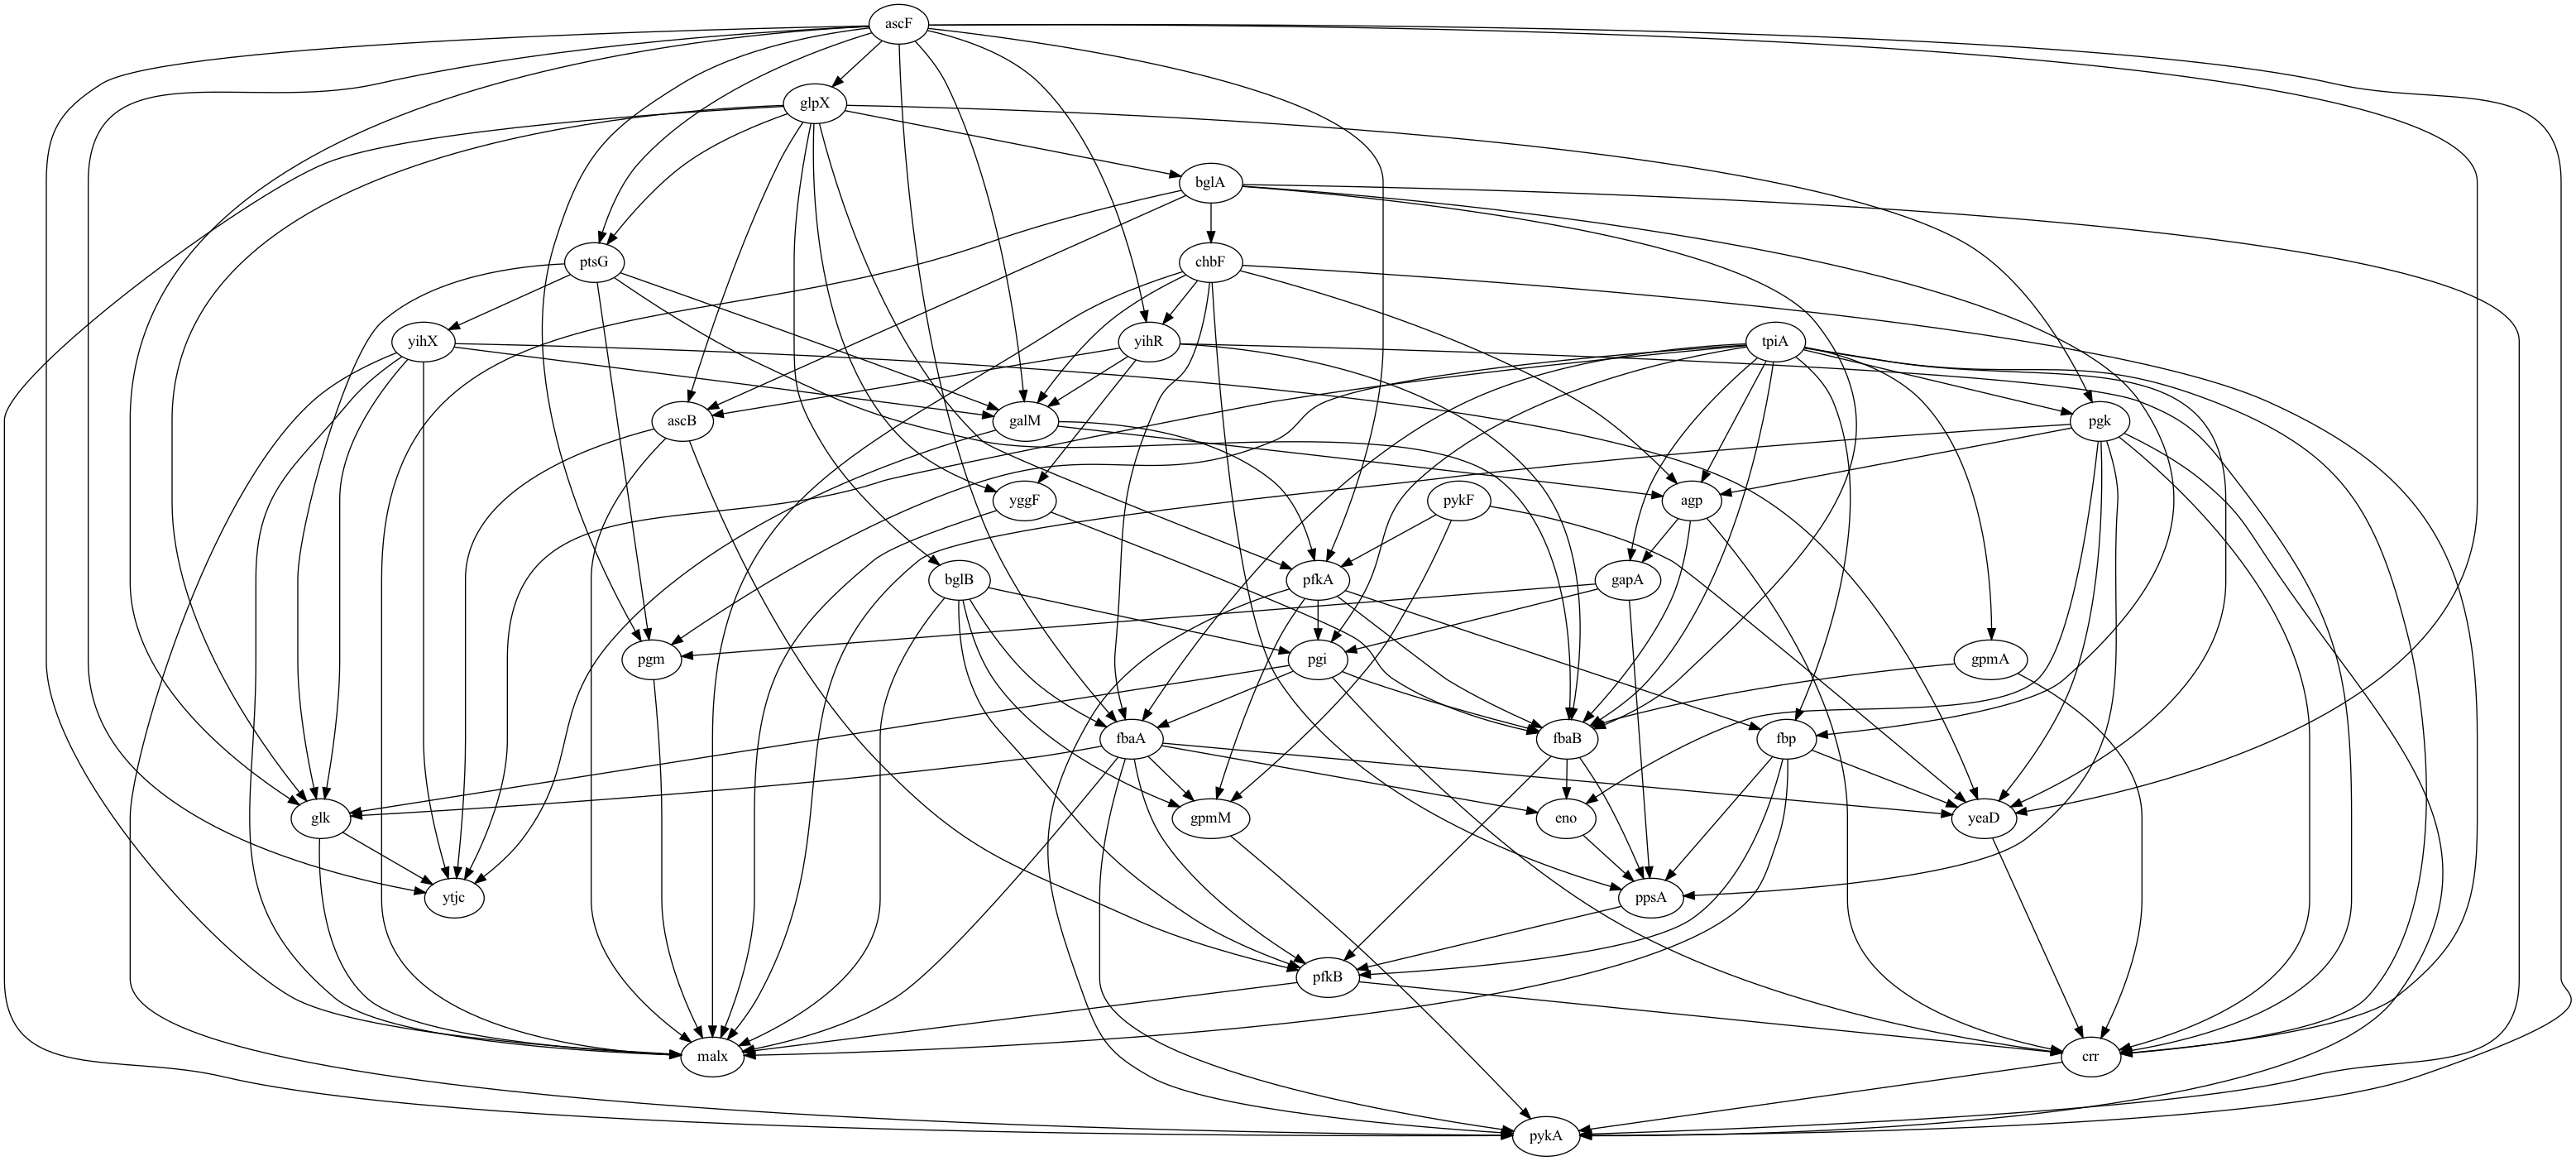

In [5]:
# スコア(エッジの数)を最大化するように設定
study = optuna.create_study(direction='minimize')
# study = optuna.multi_objective.create_study(directions=['minimize', 'minimize'])
# 100回の試行で最適化
study.optimize(objective_variable_degree(normalized_df), n_trials=100)
# ログ非表示
optuna.logging.set_verbosity(optuna.logging.WARNING) 

best_params = study.best_params
best_sm = study.best_trial.user_attrs['best_sm']
print(best_params)
print(best_sm)
view_graph_from_sm(best_sm, "a", False, True)

### 多目的最適化

In [6]:
trials = {str(trial.values): trial for trial in study.get_trials()}
trials = list(trials.values())

# グラフにプロットするため、目的変数をリストに格納する
rmsea_all_list = []
aic_all_list = []

for i, trial in enumerate(trials, start=1):
    rmsea_all_list.append(trial.values[0])
    aic_all_list.append(trial.values[1])

# パレート解の取得。get_pareto_front_trials()メソッドを使用
trials = {str(trial.values): trial for trial in study.get_pareto_front_trials()}
trials = list(trials.values())
trials.sort(key=lambda t: t.values)


# グラフプロット用にリストで取得。またパレート解の目的変数と説明変数をcsvに保存する
rmsea_list = []
aic_list = []
with open('pareto_data_real.csv', 'w') as f:
    for i, trial in enumerate(trials, start=1):
        if i == 1:
            columns_name_str = 'trial_no,rmsea,aic'
        data_list = []
        data_list.append(trial.number)
        rmsea_value = trial.values[0]
        aic_value = trial.values[1]
        rmsea_list.append(rmsea_value)
        aic_list.append(aic_value)
        data_list.append(rmsea_value)
        data_list.append(aic_value)    
        for key, value in trial.params.items():
            data_list.append(value)
            if i == 1:
                columns_name_str += ',' + key 
        if i == 1:
            f.write(columns_name_str + '\n')
        data_list = list(map(str, data_list))
        data_list_str = ','.join(data_list)
        f.write(data_list_str + '\n')

# パレート解を図示
plt.rcParams["font.size"] = 16
plt.figure(dpi=120)
plt.title("multiobjective optimization")
plt.xlabel("RMSEA")
plt.ylabel("AIC")
plt.xlim(0, 0.3)
plt.grid()
plt.scatter(rmsea_all_list, aic_all_list, c='blue', label='all trials')
plt.scatter(rmsea_list, aic_list, c='red', label='pareto front')
plt.legend()
plt.tight_layout()
plt.savefig("pareto_graph_real.png")
plt.close()

In [31]:
# # 最適化結果を取得
# thresholds = []
# l_list = []
# r_list = []

# rmseas = []
# for trial in study.trials:
#     thresholds.append(trial.params['threshold'])
#     l_list.append(trial.params['lasso_beta'])
#     r_list.append(trial.params['ridge_beta'])
#     rmseas.append(trial.value)

# # 散布図をプロット
# plt.scatter(rmseas, thresholds)
# plt.ylabel('Threshold')
# plt.xlabel('RMSEA')
# plt.title('Optimization Results: Threshold vs RMSEA')
# plt.xlim(0, 0.2)
# plt.ylim(0, max(thresholds))
# plt.show()

# # lasso_beta と rmsea のプロット
# plt.scatter(rmseas, l_list)
# plt.ylabel('Lasso Beta')
# plt.xlabel('RMSEA')
# plt.title('Optimization Results: Lasso Beta vs RMSEA')
# plt.xlim(0, 0.15)
# plt.ylim(0, 0.001)
# plt.show()

# # ridge_beta と rmsea のプロット
# plt.scatter(rmseas, r_list)
# plt.ylabel('Ridge Beta')
# plt.xlabel('RMSEA')
# plt.title('Optimization Results: Ridge Beta vs RMSEA')
# plt.xlim(0, 0.15)
# plt.ylim(0, 0.001)
# plt.show()

In [9]:
# 最適と思われるパラメータ
best_params = {
    'threshold': 0.16384558741075805,
    'lasso_beta': 0.005679386839303258,
    'ridge_beta': 0.00011298267254199744} 

### 構造学習

- 各変数の因果関係がある構造(非循環有効グラフ)のみを推定する
- 発生を促したか，抑制したかの判定はできない
- ドメイン知識として，明らかに関係のあるものはノード・エッジを追加，関係のないものは削除したい

In [41]:
# # 構造学習用関数
# def Learning(best_sm, data):

#     best_sm = pd.DataFrame(sm_to_dag_matrix(best_sm))
#     sm_SEM = run_SEM(data, best_sm, best_params['threshold'])
#     model = sm_SEM[0]
#     rmsea = sm_SEM[1]
#     value = sm_SEM[2]
    
#     return model, rmsea, value

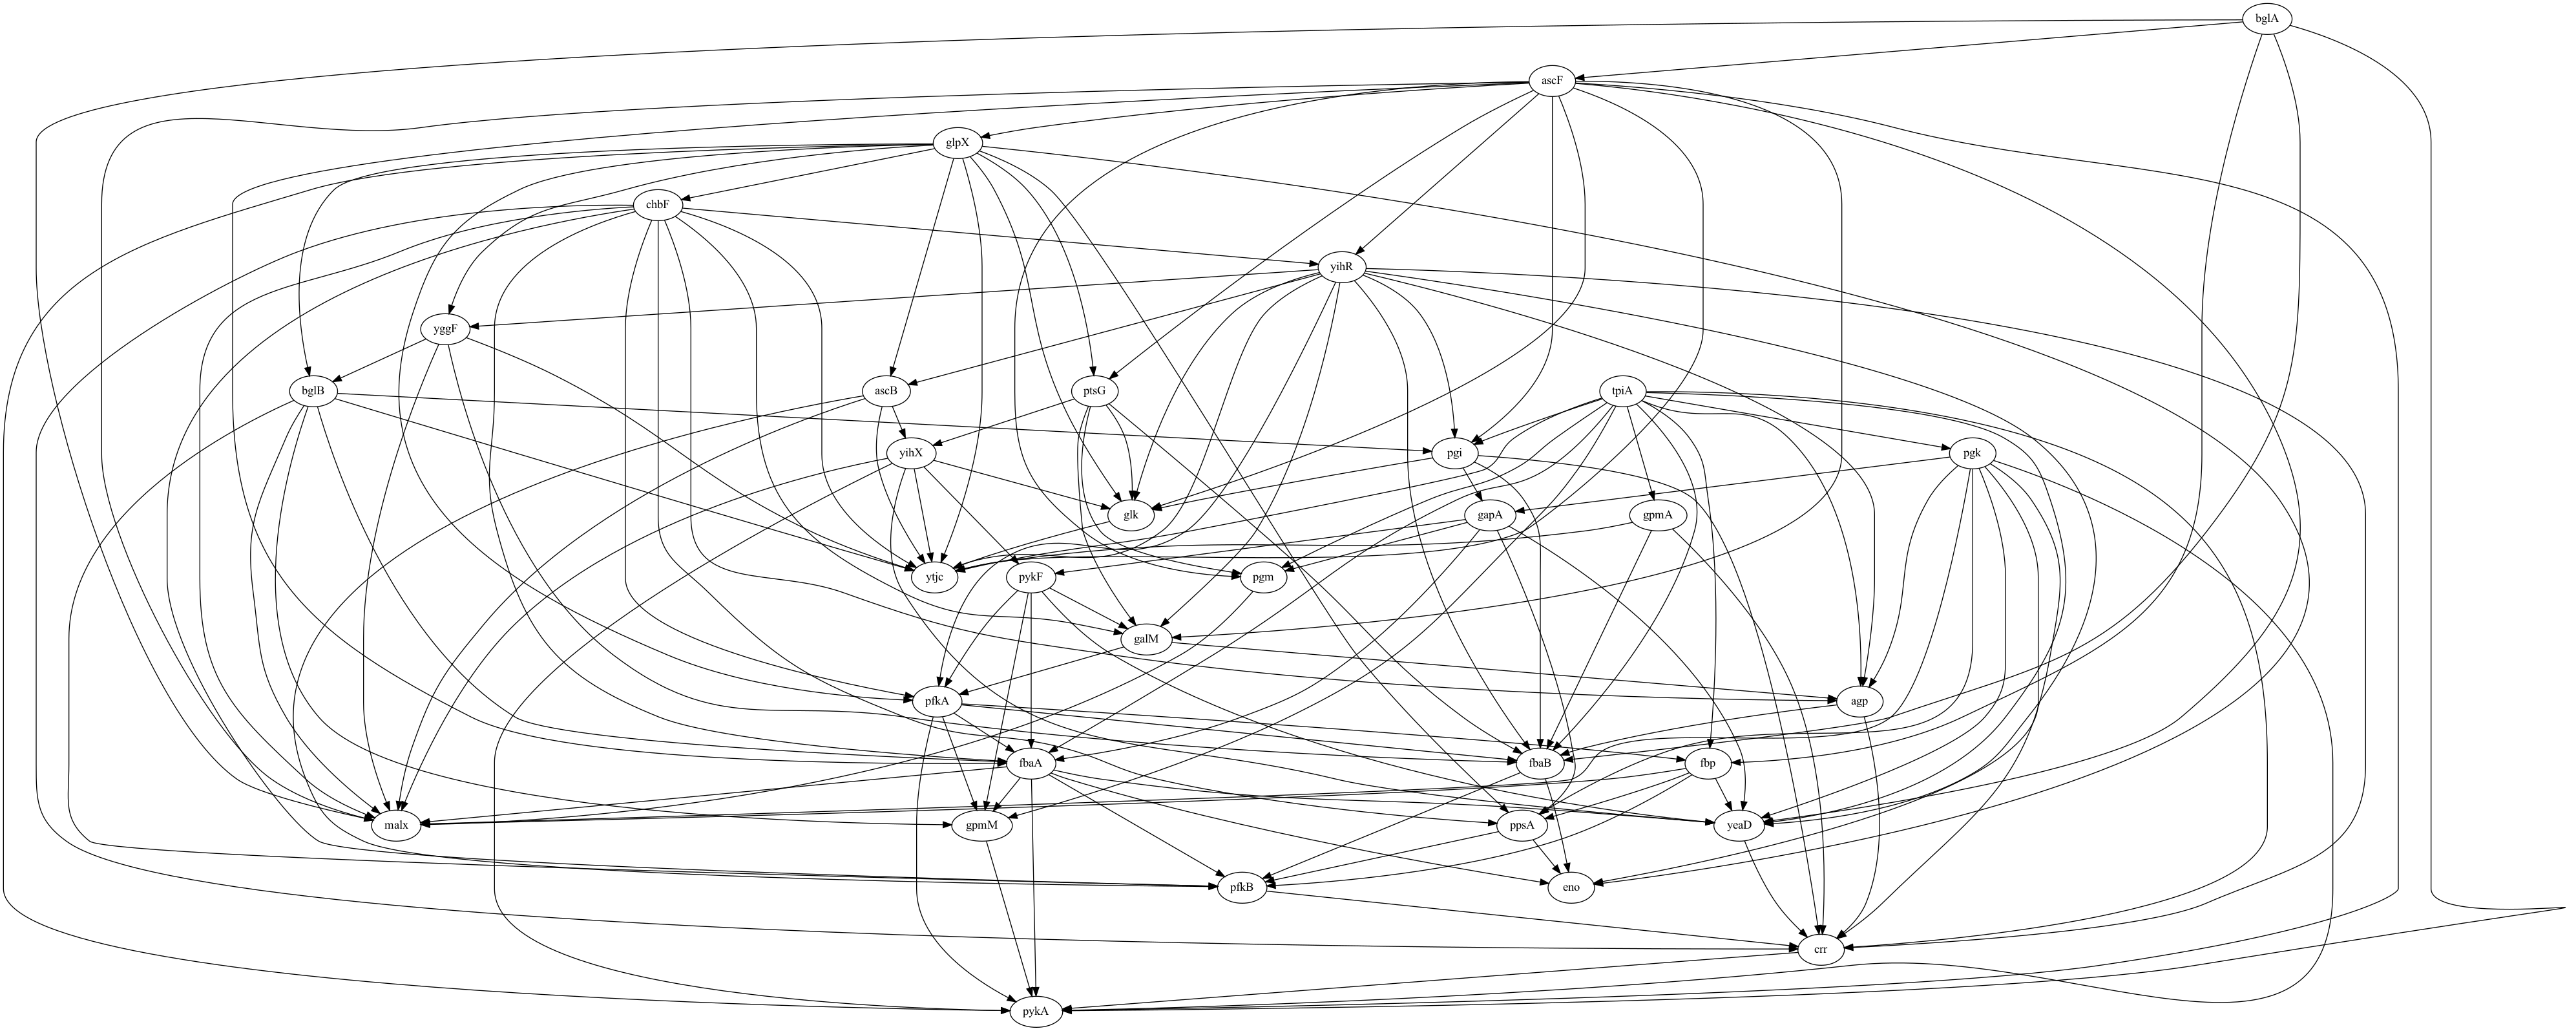

(<semopy.model.Model object at 0x16abf14c0>, array([  0.10173,   0.79571,   0.72237, 327.27314]),      lval  op  rval  Estimate  Std. Err   z-value       p-value
0     glk   ~  yihX  0.598025  0.103937  5.753701  8.731039e-09
1     glk   ~  ptsG  0.586375  0.169235  3.464847  5.305324e-04
2     glk   ~  yihR -0.478245  0.133955 -3.570177  3.567399e-04
3     glk   ~   pgi  0.299887  0.059934  5.003626  5.626199e-07
4     glk   ~  ascF  1.162029  0.252605  4.600190  4.221067e-06
..    ...  ..   ...       ...       ...       ...           ...
166  yihX  ~~  yihX  0.012543  0.001647  7.615773  2.620126e-14
167   eno  ~~   eno  0.018974  0.002491  7.615773  2.620126e-14
168  malx  ~~  malx  0.025164  0.003304  7.615773  2.620126e-14
169  pykA  ~~  pykA  0.025764  0.003383  7.615773  2.620126e-14
170  ytjc  ~~  ytjc  0.018728  0.002459  7.615773  2.620126e-14

[171 rows x 7 columns])


In [10]:
# 構造学習実行
best_sm = Learning(best_params, normalized_df)
print(best_sm)

In [12]:
# 自己回帰している部分を削除
df = best_sm[2]
df = df[df["op"] == "~"]
df

lval op  rval  Estimate  Std. Err   z-value       p-value
0     glk  ~  yihX  0.598025  0.103937  5.753701  8.731039e-09
1     glk  ~  ptsG  0.586375  0.169235  3.464847  5.305324e-04
2     glk  ~  yihR -0.478245  0.133955 -3.570177  3.567399e-04
3     glk  ~   pgi  0.299887  0.059934  5.003626  5.626199e-07
4     glk  ~  ascF  1.162029  0.252605  4.600190  4.221067e-06
..    ... ..   ...       ...       ...       ...           ...
135  pykA  ~  glpX  0.066445  0.322085  0.206297  8.365591e-01
136  pykA  ~  pfkA  0.347242  0.129481  2.681796  7.322807e-03
137  pykA  ~  fbaA  0.274676  0.112596  2.439476  1.470856e-02
138  pykA  ~   pgk  0.288825  0.089111  3.241200  1.190275e-03
139  pykA  ~  gpmM  0.301332  0.094853  3.176823  1.488977e-03

[140 rows x 7 columns]

     lval op  rval  Estimate  Std. Err   z-value  p-value
0     glk  ~  yihX  0.598025  0.103937  5.753701    0.000
1     glk  ~  ptsG  0.586375  0.169235  3.464847    0.001
2     glk  ~  yihR -0.478245  0.133955 -3.570177    0.000
3     glk  ~   pgi  0.299887  0.059934  5.003626    0.000
4     glk  ~  ascF  1.162029  0.252605  4.600190    0.000
..    ... ..   ...       ...       ...       ...      ...
132  pykA  ~   crr  0.311840  0.071133  4.383910    0.000
133  pykA  ~  ascF -1.090603  0.368035 -2.963311    0.003
136  pykA  ~  pfkA  0.347242  0.129481  2.681796    0.007
138  pykA  ~   pgk  0.288825  0.089111  3.241200    0.001
139  pykA  ~  gpmM  0.301332  0.094853  3.176823    0.001

[105 rows x 7 columns]


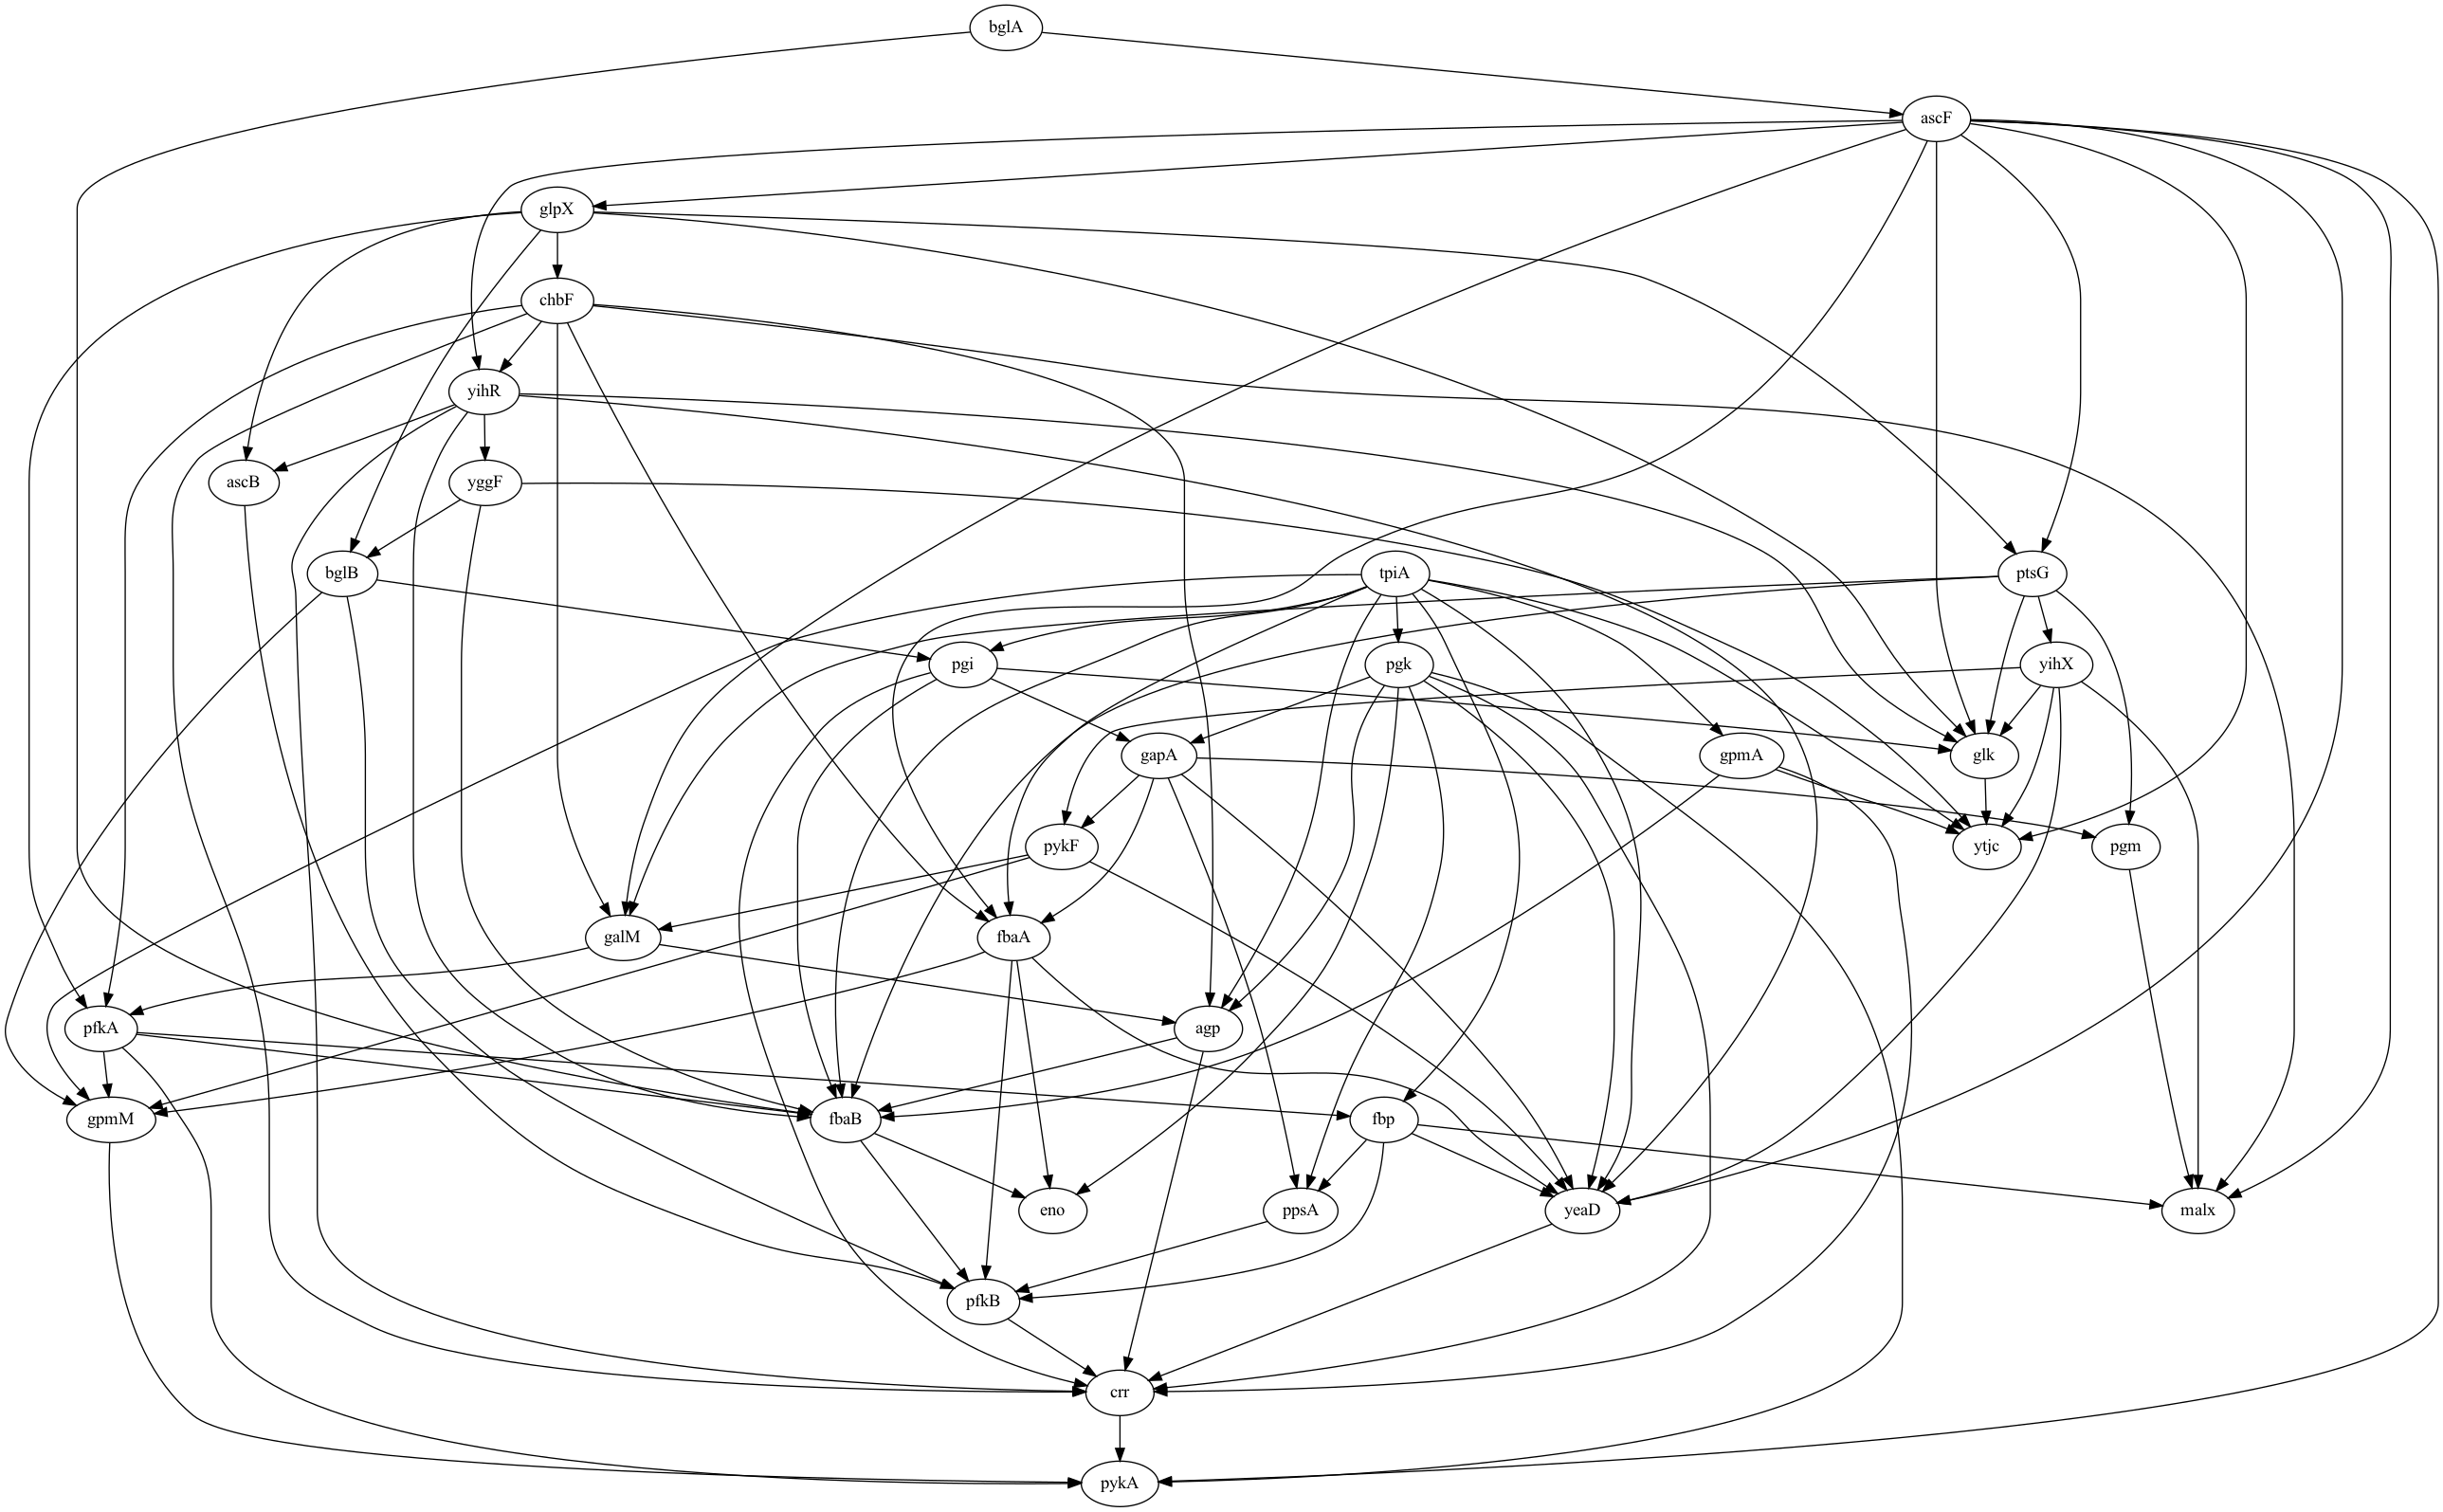

In [13]:
from causalnex.structure import StructureModel

# p値が0.05以下の行のみ抽出
df['p-value'] = df['p-value'].astype(float).map(lambda x: round(x, 3))
df = df[df['p-value'] < 0.01]

print(df)

# smモデルの作成
sm = StructureModel()
# 一行ずつ処理
for row in df.iterrows():
    # ノードを分割
    in_node = row[1]["rval"]
    out_node = row[1]["lval"]
    
    # ノードの追加
    sm.add_edges_from([(in_node, out_node)])

# パス図の描画
view_graph_from_sm(sm, "test.png")

In [89]:
import pickle

# モデルを保存
with open('best_sm.pkl_2024', 'wb') as file:
    pickle.dump(best_sm[0], file)

# 保存したモデルを読み込む
with open('best_sm.pkl_2024', 'rb') as file:
    loaded_best_sm = pickle.load(file)


## 可視化

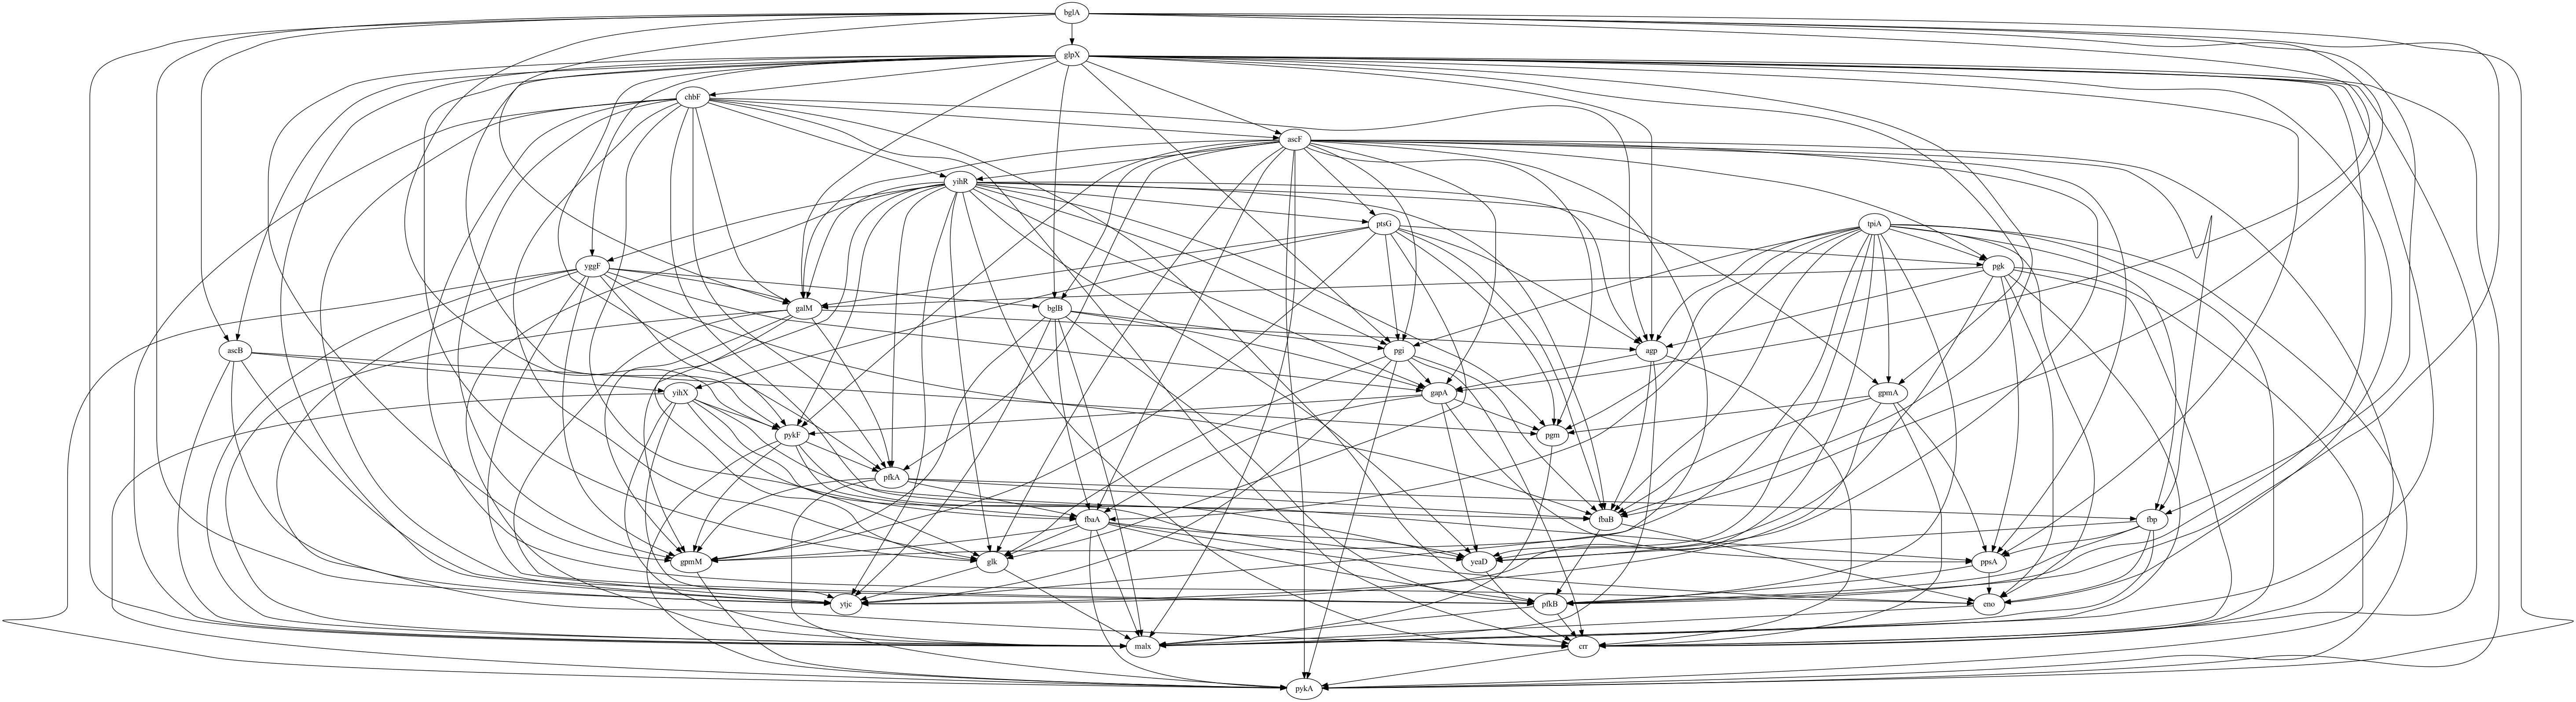

In [91]:
view_graph_from_sm(best_sm[0],"a", False, True)

## ベイジアンネットワーク

### 離散化処理

In [13]:
# Discretize the features
# Excluding the first column which seems to be an index or identifier
discretizer = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='uniform')
discretised_data = discretizer.fit_transform(normalized_df.iloc[:, :])

# Creating a new DataFrame for the discretized data
discretised_data = pd.DataFrame(discretised_data, columns=normalized_df.columns)

# ラベルを変換
# for column in discretised_data.columns:
#     discretised_data[column] = discretised_data[column].map({0.0: '発生する', 1.0: '発生しない'})

# Display the first few rows of the discretized data
# discretised_data.tail()

In [14]:
# 構造モデルのノードの確認
nodes = list(sm_l.nodes)
print('nodes:', nodes)

nodes: ['glk', 'agp', 'yihX', 'pgm', 'ptsG', 'malx', 'crr', 'galM', 'yihR', 'yeaD', 'pgi', 'ascF', 'chbF', 'ascB', 'bglA', 'bglB', 'yggF', 'glpX', 'fbp', 'pfkB', 'pfkA', 'fbaB', 'fbaA', 'tpiA', 'gapA', 'pgk', 'gpmA', 'ytjc', 'gpmM', 'eno', 'pykF', 'pykA', 'ppsA']


In [15]:
bn = BayesianNetwork(sm_l)
train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1)
bn = bn.fit_node_states(discretised_data)
bn = bn.fit_cpds(train)

for i in range(len(nodes)):
    print(nodes[i])
    display(bn.cpds[nodes[i]])

glk


ascB       0.0                                       ... 1.0                  \
ascF       0.0                                       ... 1.0                   
chbF       0.0                                       ... 1.0                   
fbaA       0.0                                       ... 1.0                   
fbaB       0.0                                       ... 1.0                   
galM       0.0                                       ... 1.0                   
glpX       0.0                                       ... 1.0                   
pgi        0.0                              1.0      ... 0.0     1.0           
ptsG       0.0              1.0             0.0      ... 1.0     0.0           
yihR       0.0      1.0     0.0     1.0     0.0      ... 1.0     0.0     1.0   
yihX       0.0 1.0  0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0  ... 0.0 1.0 0.0 1.0 0.0   
glk                                                  ...                       
0.0   0.965909 NaN  1.0 NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
1.0   0.034091 NaN  0.0 NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   

ascB                      
ascF                      
chbF                      
fbaA                      
fbaB                      
galM                      
glpX                      
pgi                       
ptsG     1.0              
yihR     0.0     1.0      
yihX 1.0 0.0 1.0 0.0 1.0  
glk                       
0.0  NaN NaN NaN NaN NaN  
1.0  NaN NaN NaN NaN NaN  

[2 rows x 2048 columns]

agp


bglA      0.0                                       ... 1.0                  \
chbF      0.0                                       ... 1.0                   
galM      0.0                                       ... 1.0                   
glpX      0.0                                       ... 1.0                   
pgk       0.0                                       ... 1.0                   
ptsG      0.0                              1.0      ... 0.0     1.0           
tpiA      0.0              1.0             0.0      ... 1.0     0.0           
yggF      0.0     1.0      0.0     1.0     0.0      ... 1.0     0.0     1.0   
yihR      0.0 1.0 0.0  1.0 0.0 1.0 0.0 1.0 0.0 1.0  ... 0.0 1.0 0.0 1.0 0.0   
agp                                                 ...                       
0.0   0.98913 NaN NaN  1.0 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
1.0   0.01087 NaN NaN  0.0 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   

bglA                      
chbF                      
galM                      
glpX                      
pgk                       
ptsG                      
tpiA     1.0              
yggF     0.0     1.0      
yihR 1.0 0.0 1.0 0.0 1.0  
agp                       
0.0  NaN NaN NaN NaN NaN  
1.0  NaN NaN NaN NaN NaN  

[2 rows x 512 columns]

yihX


ascB  0.0                                               ...  1.0            \
ascF  0.0                                     1.0       ...  0.0       1.0   
chbF  0.0                 1.0                 0.0       ...  1.0       0.0   
ptsG  0.0       1.0       0.0       1.0       0.0       ...  1.0       0.0   
tpiA  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  ...  0.0  1.0  0.0   
yihX                                                    ...                  
0.0   1.0  0.5  0.5  0.5  1.0  0.5  0.5  0.5  0.5  0.5  ...  0.5  0.5  0.5   
1.0   0.0  0.5  0.5  0.5  0.0  0.5  0.5  0.5  0.5  0.5  ...  0.5  0.5  0.5   

ascB                                     
ascF                                     
chbF                 1.0                 
ptsG       1.0       0.0       1.0       
tpiA  1.0  0.0  1.0  0.0  1.0  0.0  1.0  
yihX                                     
0.0   0.5  0.5  0.5  0.5  0.5  1.0  0.5  
1.0   0.5  0.5  0.5  0.5  0.5  0.0  0.5  

[2 rows x 32 columns]

pgm


ascB       0.0                                        ... 1.0                  \
ascF       0.0                                        ... 1.0                   
bglA       0.0                                        ... 1.0                   
galM       0.0                                        ... 1.0                   
gapA       0.0                                        ... 1.0                   
gpmA       0.0                                        ... 1.0                   
pfkA       0.0                               1.0      ... 0.0     1.0           
ptsG       0.0              1.0              0.0      ... 1.0     0.0           
tpiA       0.0      1.0     0.0     1.0      0.0      ... 1.0     0.0     1.0   
yihR       0.0  1.0 0.0 1.0 0.0 1.0 0.0 1.0  0.0 1.0  ... 0.0 1.0 0.0 1.0 0.0   
pgm                                                   ...                       
0.0   0.977778  1.0 NaN NaN NaN NaN NaN NaN  1.0 NaN  ... NaN NaN NaN NaN NaN   
1.0   0.022222  0.0 NaN NaN NaN NaN NaN NaN  0.0 NaN  ... NaN NaN NaN NaN NaN   

ascB                      
ascF                      
bglA                      
galM                      
gapA                      
gpmA                      
pfkA                      
ptsG     1.0              
tpiA     0.0     1.0      
yihR 1.0 0.0 1.0 0.0 1.0  
pgm                       
0.0  NaN NaN NaN NaN NaN  
1.0  NaN NaN NaN NaN NaN  

[2 rows x 1024 columns]

ptsG


ascF  0.0      1.0     
yihR  0.0  1.0 0.0  1.0
ptsG                   
0.0   1.0  1.0 NaN  0.0
1.0   0.0  0.0 NaN  1.0

malx


agp        0.0                                        ... 1.0                  \
ascB       0.0                                        ... 1.0                   
ascF       0.0                                        ... 1.0                   
bglA       0.0                                        ... 1.0                   
bglB       0.0                                        ... 1.0                   
chbF       0.0                                        ... 1.0                   
eno        0.0                                        ... 1.0                   
fbaA       0.0                                        ... 1.0                   
fbp        0.0                                        ... 1.0                   
galM       0.0                                        ... 1.0                   
glk        0.0                                        ... 1.0                   
glpX       0.0                                        ... 1.0                   
pfkB       0.0                                        ... 1.0                   
pgk        0.0                                        ... 1.0                   
pgm        0.0                               1.0      ... 0.0     1.0           
yggF       0.0             1.0               0.0      ... 1.0     0.0           
yihR       0.0     1.0     0.0      1.0      0.0      ... 1.0     0.0     1.0   
yihX       0.0 1.0 0.0 1.0 0.0 1.0  0.0 1.0  0.0 1.0  ... 0.0 1.0 0.0 1.0 0.0   
malx                                                  ...                       
0.0   0.961039 NaN NaN NaN NaN NaN  0.0 NaN  0.0 NaN  ... NaN NaN NaN NaN NaN   
1.0   0.038961 NaN NaN NaN NaN NaN  1.0 NaN  1.0 NaN  ... NaN NaN NaN NaN NaN   

agp                       
ascB                      
ascF                      
bglA                      
bglB                      
chbF                      
eno                       
fbaA                      
fbp                       
galM                      
glk                       
glpX                      
pfkB                      
pgk                       
pgm                       
yggF     1.0              
yihR     0.0     1.0      
yihX 1.0 0.0 1.0 0.0 1.0  
malx                      
0.0  NaN NaN NaN NaN NaN  
1.0  NaN NaN NaN NaN NaN  

[2 rows x 262144 columns]

crr


agp       0.0                                        ... 1.0                  \
ascF      0.0                                        ... 1.0                   
bglA      0.0                                        ... 1.0                   
chbF      0.0                                        ... 1.0                   
glpX      0.0                                        ... 1.0                   
gpmA      0.0                                        ... 1.0                   
pfkB      0.0                                        ... 1.0                   
pgi       0.0                                        ... 1.0                   
pgk       0.0                                        ... 1.0                   
pykF      0.0                                        ... 1.0                   
tpiA      0.0                                        ... 1.0                   
yeaD      0.0                               1.0      ... 0.0     1.0           
yggF      0.0             1.0               0.0      ... 1.0     0.0           
yihR      0.0     1.0     0.0      1.0      0.0      ... 1.0     0.0     1.0   
yihX      0.0 1.0 0.0 1.0 0.0 1.0  0.0 1.0  0.0 1.0  ... 0.0 1.0 0.0 1.0 0.0   
crr                                                  ...                       
0.0   0.83908 NaN NaN NaN NaN NaN  1.0 NaN  1.0 NaN  ... NaN NaN NaN NaN NaN   
1.0   0.16092 NaN NaN NaN NaN NaN  0.0 NaN  0.0 NaN  ... NaN NaN NaN NaN NaN   

agp                       
ascF                      
bglA                      
chbF                      
glpX                      
gpmA                      
pfkB                      
pgi                       
pgk                       
pykF                      
tpiA                      
yeaD                      
yggF     1.0              
yihR     0.0     1.0      
yihX 1.0 0.0 1.0 0.0 1.0  
crr                       
0.0  NaN NaN NaN NaN NaN  
1.0  NaN NaN NaN NaN NaN  

[2 rows x 32768 columns]

galM


ascF   0.0                                        ... 1.0                      \
bglA   0.0                                        ... 1.0                       
chbF   0.0                                        ... 1.0                       
glpX   0.0                                        ... 1.0                       
pgk    0.0                               1.0      ... 0.0     1.0               
ptsG   0.0              1.0              0.0      ... 1.0     0.0               
yggF   0.0     1.0      0.0     1.0      0.0      ... 1.0     0.0     1.0       
yihR   0.0 1.0 0.0  1.0 0.0 1.0 0.0 1.0  0.0 1.0  ... 0.0 1.0 0.0 1.0 0.0 1.0   
galM                                              ...                           
0.0   0.92 NaN NaN  1.0 NaN NaN NaN NaN  0.0 NaN  ... NaN NaN NaN NaN NaN NaN   
1.0   0.08 NaN NaN  0.0 NaN NaN NaN NaN  1.0 NaN  ... NaN NaN NaN NaN NaN NaN   

ascF                   
bglA                   
chbF                   
glpX                   
pgk                    
ptsG 1.0               
yggF 0.0     1.0       
yihR 0.0 1.0 0.0  1.0  
galM                   
0.0  NaN NaN NaN  1.0  
1.0  NaN NaN NaN  0.0  

[2 rows x 256 columns]

yihR


ascF       0.0              1.0             
chbF       0.0      1.0     0.0     1.0     
glpX       0.0 1.0  0.0 1.0 0.0 1.0 0.0  1.0
yihR                                        
0.0   0.990196 NaN  1.0 NaN NaN NaN NaN  0.0
1.0   0.009804 NaN  0.0 NaN NaN NaN NaN  1.0

yeaD


ascF       0.0                                       ... 1.0                  \
fbaA       0.0                                       ... 1.0                   
fbp        0.0                                       ... 1.0                   
gapA       0.0                                       ... 1.0                   
pgk        0.0                                       ... 1.0                   
pykF       0.0                              1.0      ... 0.0     1.0           
tpiA       0.0              1.0             0.0      ... 1.0     0.0           
yihR       0.0      1.0     0.0     1.0     0.0      ... 1.0     0.0     1.0   
yihX       0.0 1.0  0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0  ... 0.0 1.0 0.0 1.0 0.0   
yeaD                                                 ...                       
0.0   0.989796 NaN  1.0 NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
1.0   0.010204 NaN  0.0 NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   

ascF                      
fbaA                      
fbp                       
gapA                      
pgk                       
pykF                      
tpiA     1.0              
yihR     0.0     1.0      
yihX 1.0 0.0 1.0 0.0 1.0  
yeaD                      
0.0  NaN NaN NaN NaN NaN  
1.0  NaN NaN NaN NaN NaN  

[2 rows x 512 columns]

pgi


ascF       0.0                                       ... 1.0                  \
bglB       0.0                                       ... 1.0                   
glpX       0.0                              1.0      ... 0.0     1.0           
ptsG       0.0              1.0             0.0      ... 1.0     0.0           
tpiA       0.0      1.0     0.0     1.0     0.0      ... 1.0     0.0     1.0   
yihR       0.0  1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0  ... 0.0 1.0 0.0 1.0 0.0   
pgi                                                  ...                       
0.0   0.980392  1.0 NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
1.0   0.019608  0.0 NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   

ascF                       
bglB                       
glpX                       
ptsG     1.0               
tpiA     0.0      1.0      
yihR 1.0 0.0  1.0 0.0 1.0  
pgi                        
0.0  NaN NaN  1.0 NaN NaN  
1.0  NaN NaN  0.0 NaN NaN  

[2 rows x 64 columns]

ascF


chbF  0.0      1.0     
glpX  0.0 1.0  0.0  1.0
ascF                   
0.0   1.0 NaN  1.0  0.0
1.0   0.0 NaN  0.0  1.0

chbF


glpX       0.0  1.0
chbF               
0.0   0.990291  0.0
1.0   0.009709  1.0

ascB


bglA       0.0     1.0     
glpX       0.0 1.0 0.0  1.0
ascB                       
0.0   0.990291 NaN NaN  0.0
1.0   0.009709 NaN NaN  1.0

bglA


bglA          
0.0   0.990385
1.0   0.009615

bglB


ascF  0.0                              1.0                             
glpX  0.0              1.0             0.0             1.0             
ptsG  0.0      1.0     0.0     1.0     0.0     1.0     0.0     1.0     
yggF  0.0  1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0  1.0
bglB                                                                   
0.0   1.0  1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  0.0
1.0   0.0  0.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  1.0

yggF


glpX  0.0              1.0             
ptsG  0.0      1.0     0.0     1.0     
yihR  0.0  1.0 0.0 1.0 0.0 1.0 0.0  1.0
yggF                                   
0.0   1.0  0.0 NaN NaN NaN NaN NaN  0.0
1.0   0.0  1.0 NaN NaN NaN NaN NaN  1.0

glpX


bglA  0.0  1.0
glpX          
0.0   1.0  0.0
1.0   0.0  1.0

fbp


agp   0.0                                               ...  1.0            \
ascF  0.0                                               ...  1.0             
bglA  0.0                                               ...  1.0             
chbF  0.0                                     1.0       ...  0.0       1.0   
pfkA  0.0                 1.0                 0.0       ...  1.0       0.0   
pykF  0.0       1.0       0.0       1.0       0.0       ...  1.0       0.0   
tpiA  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  ...  0.0  1.0  0.0   
fbp                                                     ...                  
0.0   1.0  0.5  0.5  0.5  1.0  0.5  0.5  0.5  1.0  0.5  ...  0.5  0.5  0.5   
1.0   0.0  0.5  0.5  0.5  0.0  0.5  0.5  0.5  0.0  0.5  ...  0.5  0.5  0.5   

agp                                      
ascF                                     
bglA                                     
chbF                                     
pfkA                 1.0                 
pykF       1.0       0.0       1.0       
tpiA  1.0  0.0  1.0  0.0  1.0  0.0  1.0  
fbp                                      
0.0   0.5  0.5  0.5  0.5  0.5  0.5  0.5  
1.0   0.5  0.5  0.5  0.5  0.5  0.5  0.5  

[2 rows x 128 columns]

pfkB


ascB       0.0                                         ... 1.0              \
bglA       0.0                                         ... 1.0               
bglB       0.0                                         ... 1.0               
chbF       0.0                                         ... 1.0               
fbaA       0.0                                         ... 1.0               
fbaB       0.0                                         ... 1.0               
fbp        0.0                                         ... 1.0               
galM       0.0                                         ... 1.0               
glpX       0.0                                1.0      ... 0.0     1.0       
gpmA       0.0                1.0             0.0      ... 1.0     0.0       
ppsA       0.0       1.0      0.0     1.0     0.0      ... 1.0     0.0       
tpiA       0.0 1.0   0.0 1.0  0.0 1.0 0.0 1.0 0.0 1.0  ... 0.0 1.0 0.0 1.0   
pfkB                                                   ...                   
0.0   0.952381 NaN  0.75 NaN  1.0 NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN   
1.0   0.047619 NaN  0.25 NaN  0.0 NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN   

ascB                          
bglA                          
bglB                          
chbF                          
fbaA                          
fbaB                          
fbp                           
galM                          
glpX                          
gpmA         1.0              
ppsA 1.0     0.0     1.0      
tpiA 0.0 1.0 0.0 1.0 0.0 1.0  
pfkB                          
0.0  NaN NaN NaN NaN NaN NaN  
1.0  NaN NaN NaN NaN NaN NaN  

[2 rows x 4096 columns]

pfkA


ascF      0.0                                             ... 1.0              \
chbF      0.0                                             ... 1.0               
galM      0.0                                    1.0      ... 0.0     1.0       
glpX      0.0              1.0                   0.0      ... 1.0     0.0       
pykF      0.0      1.0     0.0     1.0           0.0      ... 1.0     0.0       
yihR      0.0  1.0 0.0 1.0 0.0 1.0 0.0 1.0       0.0 1.0  ... 0.0 1.0 0.0 1.0   
pfkA                                                      ...                   
0.0   0.98913  1.0 NaN NaN NaN NaN NaN NaN  0.888889 NaN  ... NaN NaN NaN NaN   
1.0   0.01087  0.0 NaN NaN NaN NaN NaN NaN  0.111111 NaN  ... NaN NaN NaN NaN   

ascF                          
chbF                          
galM                          
glpX         1.0              
pykF 1.0     0.0     1.0      
yihR 0.0 1.0 0.0 1.0 0.0 1.0  
pfkA                          
0.0  NaN NaN NaN NaN NaN NaN  
1.0  NaN NaN NaN NaN NaN NaN  

[2 rows x 64 columns]

fbaB


agp        0.0                                       ... 1.0                  \
bglA       0.0                                       ... 1.0                   
glpX       0.0                                       ... 1.0                   
gpmA       0.0                                       ... 1.0                   
pfkA       0.0                                       ... 1.0                   
pgi        0.0                                       ... 1.0                   
ptsG       0.0                                       ... 1.0                   
tpiA       0.0                              1.0      ... 0.0     1.0           
yggF       0.0             1.0              0.0      ... 1.0     0.0           
yihR       0.0     1.0     0.0      1.0     0.0      ... 1.0     0.0     1.0   
yihX       0.0 1.0 0.0 1.0 0.0 1.0  0.0 1.0 0.0 1.0  ... 0.0 1.0 0.0 1.0 0.0   
fbaB                                                 ...                       
0.0   0.979381 NaN NaN NaN NaN NaN  1.0 NaN NaN NaN  ... NaN NaN NaN NaN NaN   
1.0   0.020619 NaN NaN NaN NaN NaN  0.0 NaN NaN NaN  ... NaN NaN NaN NaN NaN   

agp                       
bglA                      
glpX                      
gpmA                      
pfkA                      
pgi                       
ptsG                      
tpiA                      
yggF     1.0              
yihR     0.0     1.0      
yihX 1.0 0.0 1.0 0.0 1.0  
fbaB                      
0.0  NaN NaN NaN NaN NaN  
1.0  NaN NaN NaN NaN NaN  

[2 rows x 2048 columns]

fbaA


ascF  0.0                                      ... 1.0                      \
bglB  0.0                                      ... 1.0                       
chbF  0.0                                      ... 1.0                       
galM  0.0                                      ... 1.0                       
gapA  0.0                                      ... 1.0                       
pfkA  0.0                             1.0      ... 0.0     1.0               
pgi   0.0             1.0             0.0      ... 1.0     0.0               
pykF  0.0     1.0     0.0     1.0     0.0      ... 1.0     0.0     1.0       
tpiA  0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0  ... 0.0 1.0 0.0 1.0 0.0 1.0   
fbaA                                           ...                           
0.0   1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN   
1.0   0.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN   

ascF                  
bglB                  
chbF                  
galM                  
gapA                  
pfkA                  
pgi  1.0              
pykF 0.0     1.0      
tpiA 0.0 1.0 0.0 1.0  
fbaA                  
0.0  NaN NaN NaN NaN  
1.0  NaN NaN NaN NaN  

[2 rows x 512 columns]

tpiA


tpiA     
0.0   1.0
1.0   0.0

gapA


agp        0.0                                        ... 1.0                  \
ascF       0.0                                        ... 1.0                   
bglA       0.0                                        ... 1.0                   
bglB       0.0                               1.0      ... 0.0     1.0           
pgi        0.0               1.0             0.0      ... 1.0     0.0           
yggF       0.0     1.0       0.0     1.0     0.0      ... 1.0     0.0     1.0   
yihR       0.0 1.0 0.0  1.0  0.0 1.0 0.0 1.0 0.0 1.0  ... 0.0 1.0 0.0 1.0 0.0   
gapA                                                  ...                       
0.0   0.989796 NaN NaN  1.0  1.0 NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
1.0   0.010204 NaN NaN  0.0  0.0 NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   

agp                       
ascF                      
bglA                      
bglB                      
pgi      1.0              
yggF     0.0     1.0      
yihR 1.0 0.0 1.0 0.0 1.0  
gapA                      
0.0  NaN NaN NaN NaN NaN  
1.0  NaN NaN NaN NaN NaN  

[2 rows x 128 columns]

pgk


ascF  0.0                                        ... 1.0                       \
chbF  0.0                               1.0      ... 0.0     1.0                
pgi   0.0              1.0              0.0      ... 1.0     0.0                
ptsG  0.0     1.0      0.0     1.0      0.0      ... 1.0     0.0      1.0       
tpiA  0.0 1.0 0.0 1.0  0.0 1.0 0.0 1.0  0.0 1.0  ... 0.0 1.0 0.0 1.0  0.0 1.0   
pgk                                              ...                            
0.0   1.0 NaN NaN NaN  0.5 NaN NaN NaN  1.0 NaN  ... NaN NaN NaN NaN  0.0 NaN   
1.0   0.0 NaN NaN NaN  0.5 NaN NaN NaN  0.0 NaN  ... NaN NaN NaN NaN  1.0 NaN   

ascF                  
chbF                  
pgi  1.0              
ptsG 0.0     1.0      
tpiA 0.0 1.0 0.0 1.0  
pgk                   
0.0  NaN NaN NaN NaN  
1.0  NaN NaN NaN NaN  

[2 rows x 32 columns]

gpmA


ascB      0.0                                        ... 1.0                  \
galM      0.0                               1.0      ... 0.0     1.0           
glpX      0.0              1.0              0.0      ... 1.0     0.0           
tpiA      0.0      1.0     0.0     1.0      0.0      ... 1.0     0.0     1.0   
yihR      0.0  1.0 0.0 1.0 0.0 1.0 0.0 1.0  0.0 1.0  ... 0.0 1.0 0.0 1.0 0.0   
gpmA                                                 ...                       
0.0   0.98913  1.0 NaN NaN NaN NaN NaN NaN  1.0 NaN  ... NaN NaN NaN NaN NaN   
1.0   0.01087  0.0 NaN NaN NaN NaN NaN NaN  0.0 NaN  ... NaN NaN NaN NaN NaN   

ascB                      
galM                      
glpX     1.0              
tpiA     0.0     1.0      
yihR 1.0 0.0 1.0 0.0 1.0  
gpmA                      
0.0  NaN NaN NaN NaN NaN  
1.0  NaN NaN NaN NaN NaN  

[2 rows x 32 columns]

ytjc


ascB       0.0                                       ... 1.0                  \
ascF       0.0                                       ... 1.0                   
bglA       0.0                                       ... 1.0                   
bglB       0.0                                       ... 1.0                   
chbF       0.0                                       ... 1.0                   
glk        0.0                                       ... 1.0                   
glpX       0.0                                       ... 1.0                   
gpmA       0.0                                       ... 1.0                   
pfkA       0.0                                       ... 1.0                   
pgi        0.0                                       ... 1.0                   
tpiA       0.0                              1.0      ... 0.0     1.0           
yggF       0.0             1.0              0.0      ... 1.0     0.0           
yihR       0.0     1.0     0.0      1.0     0.0      ... 1.0     0.0     1.0   
yihX       0.0 1.0 0.0 1.0 0.0 1.0  0.0 1.0 0.0 1.0  ... 0.0 1.0 0.0 1.0 0.0   
ytjc                                                 ...                       
0.0   0.945652 NaN NaN NaN NaN NaN  1.0 NaN NaN NaN  ... NaN NaN NaN NaN NaN   
1.0   0.054348 NaN NaN NaN NaN NaN  0.0 NaN NaN NaN  ... NaN NaN NaN NaN NaN   

ascB                      
ascF                      
bglA                      
bglB                      
chbF                      
glk                       
glpX                      
gpmA                      
pfkA                      
pgi                       
tpiA                      
yggF     1.0              
yihR     0.0     1.0      
yihX 1.0 0.0 1.0 0.0 1.0  
ytjc                      
0.0  NaN NaN NaN NaN NaN  
1.0  NaN NaN NaN NaN NaN  

[2 rows x 16384 columns]

gpmM


ascB       0.0                                       ... 1.0                  \
bglB       0.0                                       ... 1.0                   
chbF       0.0                                       ... 1.0                   
fbaA       0.0                                       ... 1.0                   
galM       0.0                                       ... 1.0                   
glpX       0.0                                       ... 1.0                   
pfkA       0.0                                       ... 1.0                   
ptsG       0.0                                       ... 1.0                   
pykF       0.0                              1.0      ... 0.0     1.0           
tpiA       0.0              1.0             0.0      ... 1.0     0.0           
yggF       0.0     1.0      0.0     1.0     0.0      ... 1.0     0.0     1.0   
yihR       0.0 1.0 0.0  1.0 0.0 1.0 0.0 1.0 0.0 1.0  ... 0.0 1.0 0.0 1.0 0.0   
gpmM                                                 ...                       
0.0   0.988889 NaN NaN  1.0 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
1.0   0.011111 NaN NaN  0.0 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   

ascB                      
bglB                      
chbF                      
fbaA                      
galM                      
glpX                      
pfkA                      
ptsG                      
pykF                      
tpiA     1.0              
yggF     0.0     1.0      
yihR 1.0 0.0 1.0 0.0 1.0  
gpmM                      
0.0  NaN NaN NaN NaN NaN  
1.0  NaN NaN NaN NaN NaN  

[2 rows x 4096 columns]

eno


chbF  0.0                                            ... 1.0                  \
fbaA  0.0                                            ... 1.0                   
fbaB  0.0                                            ... 1.0                   
fbp   0.0                                            ... 1.0                   
glpX  0.0                                   1.0      ... 0.0     1.0           
pgk   0.0                   1.0             0.0      ... 1.0     0.0           
ppsA  0.0           1.0     0.0     1.0     0.0      ... 1.0     0.0     1.0   
tpiA  0.0 1.0       0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0  ... 0.0 1.0 0.0 1.0 0.0   
eno                                                  ...                       
0.0   1.0 NaN  0.833333 NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
1.0   0.0 NaN  0.166667 NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   

chbF                      
fbaA                      
fbaB                      
fbp                       
glpX                      
pgk      1.0              
ppsA     0.0     1.0      
tpiA 1.0 0.0 1.0 0.0 1.0  
eno                       
0.0  NaN NaN NaN NaN NaN  
1.0  NaN NaN NaN NaN NaN  

[2 rows x 256 columns]

pykF


ascF  0.0                                               ...  1.0            \
bglA  0.0                                               ...  1.0             
gapA  0.0                                               ...  1.0             
glpX  0.0                                     1.0       ...  0.0       1.0   
yggF  0.0                 1.0                 0.0       ...  1.0       0.0   
yihR  0.0       1.0       0.0       1.0       0.0       ...  1.0       0.0   
yihX  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  ...  0.0  1.0  0.0   
pykF                                                    ...                  
0.0   1.0  0.5  0.5  0.5  0.5  0.5  1.0  0.5  0.5  0.5  ...  0.5  0.5  0.5   
1.0   0.0  0.5  0.5  0.5  0.5  0.5  0.0  0.5  0.5  0.5  ...  0.5  0.5  0.5   

ascF                                     
bglA                                     
gapA                                     
glpX                                     
yggF                 1.0                 
yihR       1.0       0.0       1.0       
yihX  1.0  0.0  1.0  0.0  1.0  0.0  1.0  
pykF                                     
0.0   0.5  0.5  0.5  0.5  0.5  0.5  0.5  
1.0   0.5  0.5  0.5  0.5  0.5  0.5  0.5  

[2 rows x 128 columns]

pykA


ascF       0.0                                        ... 1.0                  \
bglA       0.0                                        ... 1.0                   
bglB       0.0                                        ... 1.0                   
crr        0.0                                        ... 1.0                   
fbaA       0.0                                        ... 1.0                   
glpX       0.0                                        ... 1.0                   
gpmM       0.0                                        ... 1.0                   
pfkA       0.0                                        ... 1.0                   
pgi        0.0                                        ... 1.0                   
pgk        0.0                                        ... 1.0                   
pykF       0.0                                        ... 1.0                   
tpiA       0.0                               1.0      ... 0.0     1.0           
yggF       0.0               1.0             0.0      ... 1.0     0.0           
yihX       0.0      1.0      0.0     1.0     0.0      ... 1.0     0.0     1.0   
ytjc       0.0  1.0 0.0 1.0  0.0 1.0 0.0 1.0 0.0 1.0  ... 0.0 1.0 0.0 1.0 0.0   
pykA                                                  ...                       
0.0   0.863014  1.0 NaN NaN  1.0 NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
1.0   0.136986  0.0 NaN NaN  0.0 NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   

ascF                      
bglA                      
bglB                      
crr                       
fbaA                      
glpX                      
gpmM                      
pfkA                      
pgi                       
pgk                       
pykF                      
tpiA                      
yggF     1.0              
yihX     0.0     1.0      
ytjc 1.0 0.0 1.0 0.0 1.0  
pykA                      
0.0  NaN NaN NaN NaN NaN  
1.0  NaN NaN NaN NaN NaN  

[2 rows x 32768 columns]

ppsA


ascF       0.0                                        ... 1.0                  \
bglA       0.0                                        ... 1.0                   
chbF       0.0                                        ... 1.0                   
fbaB       0.0                                        ... 1.0                   
fbp        0.0                                        ... 1.0                   
gapA       0.0                               1.0      ... 0.0     1.0           
glpX       0.0              1.0              0.0      ... 1.0     0.0           
gpmA       0.0      1.0     0.0     1.0      0.0      ... 1.0     0.0     1.0   
pgk        0.0 1.0  0.0 1.0 0.0 1.0 0.0 1.0  0.0 1.0  ... 0.0 1.0 0.0 1.0 0.0   
ppsA                                                  ...                       
0.0   0.938144 NaN  1.0 NaN NaN NaN NaN NaN  0.0 NaN  ... NaN NaN NaN NaN NaN   
1.0   0.061856 NaN  0.0 NaN NaN NaN NaN NaN  1.0 NaN  ... NaN NaN NaN NaN NaN   

ascF                      
bglA                      
chbF                      
fbaB                      
fbp                       
gapA                      
glpX     1.0              
gpmA     0.0     1.0      
pgk  1.0 0.0 1.0 0.0 1.0  
ppsA                      
0.0  NaN NaN NaN NaN NaN  
1.0  NaN NaN NaN NaN NaN  

[2 rows x 512 columns]

### 評価

In [ ]:
# predictions = bn.predict(discretised_data, "pgi")
# print(discretised_data.loc[1, "pgi"])

In [ ]:
# display(classification_report(bn, test, "pgi"))

### 各変数のAUC

In [13]:
# for n in bn.nodes:
#     roc, auc = roc_auc(bn, test, n)
#     print(n, auc)

### 条件付き確率の可視化

Saved as: ././output/simple_cpds/cpd_6.png


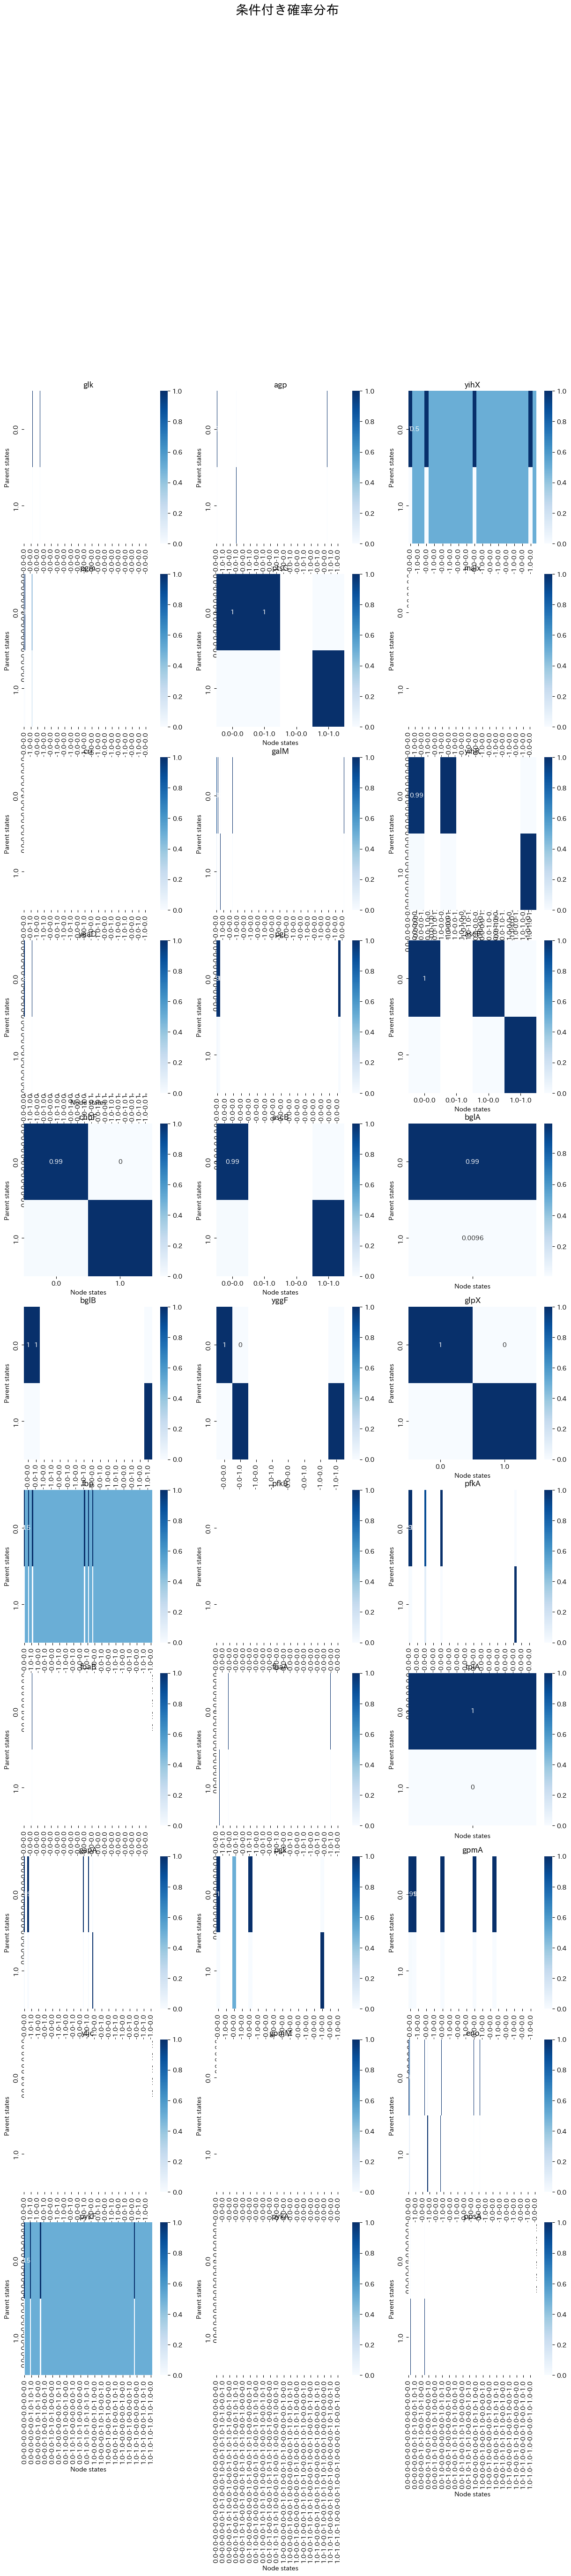

In [16]:
# ノードの数に基づいてサブプロットの行と列の数を決定
num_nodes = len(nodes)

cols = 3  # 1行に表示するヒートマップの数
rows = num_nodes // cols + (num_nodes % cols > 0)

# サブプロットのグリッドを作成
fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 5), squeeze=False)

# ネットワークのタイトル
plt.suptitle('条件付き確率分布', y=1.03, fontsize=20)

for i, node in enumerate(nodes):
    cpd = bn.cpds[node]
    cpd_df = pd.DataFrame(cpd)

    # 対応するサブプロットにヒートマップを描画
    row, col = divmod(i, cols)
    sns.heatmap(cpd_df, annot=True, cmap='Blues', ax=axs[row, col])

    axs[row, col].set_title(f'{node}')
    axs[row, col].set_ylabel('Parent states' if cpd_df.shape[0] > 1 else 'State')
    axs[row, col].set_xlabel('Node states')

# 空のサブプロットを非表示にする
for i in range(num_nodes, rows * cols):
    axs[i // cols, i % cols].axis('off')

plt.tight_layout()
# 保存先指定
file_path = create_filename('./output/simple_cpds/cpd')
plt.savefig(file_path, format="png", dpi=300, bbox_inches='tight')

print(f"Saved as: {file_path}")

### 介入によるシミュレーション

In [65]:
print('nodes:', nodes)

nodes: ['glk', 'yihX', 'pgm', 'ptsG', 'crr', 'yihR', 'yeaD', 'pgi', 'ascF', 'chbF', 'ascB', 'bglA', 'bglB', 'glpX', 'fbp', 'pfkB', 'fbaB', 'fbaA', 'tpiA', 'pgk', 'gpmA', 'eno', 'pykF', 'pykA']


In [66]:
# InferenceEngineを初期化
engine = InferenceEngine(bn)


print(f"介入前の{nodes[12]}: ", engine.query())

engine.query()

介入前のbglB:  {'yihX': {0.0: 0.9947089947089945, 1.0: 0.005291005291005281}, 'pgm': {0.0: 0.9947089947089944, 1.0: 0.005291005291005283}, 'crr': {0.0: 0.9895296721253438, 1.0: 0.010470327874655827}, 'pgi': {0.0: 0.95425664108358, 1.0: 0.04574335891642131}, 'fbaA': {0.0: 0.9894176883993119, 1.0: 0.010582311600687863}, 'pgk': {0.0: 0.9788359788359784, 1.0: 0.021164021164021156}, 'gpmA': {0.0: 0.9788359788359785, 1.0: 0.021164021164021156}, 'ptsG': {0.0: 0.9894179894179903, 1.0: 0.010582010582010554}, 'yihR': {0.0: 0.9894179894179903, 1.0: 0.010582010582010555}, 'glk': {0.0: 0.9841269841269836, 1.0: 0.015873015873015837}, 'chbF': {0.0: 0.9894179894179903, 1.0: 0.010582010582010555}, 'fbaB': {0.0: 0.9894739788919679, 1.0: 0.01052602110803167}, 'pykF': {0.0: 0.9788359788359784, 1.0: 0.021164021164021125}, 'yeaD': {0.0: 0.9841269841269846, 1.0: 0.015873015873015872}, 'fbp': {0.0: 0.9869615262791421, 1.0: 0.013038473720857112}, 'ascF': {0.0: 0.9894179894179903, 1.0: 0.010582010582010555}, 'ascB'

{'yihX': {0.0: 0.9947089947089945, 1.0: 0.005291005291005281},
 'pgm': {0.0: 0.9947089947089944, 1.0: 0.005291005291005283},
 'crr': {0.0: 0.9895296721253438, 1.0: 0.010470327874655827},
 'pgi': {0.0: 0.95425664108358, 1.0: 0.04574335891642131},
 'fbaA': {0.0: 0.9894176883993119, 1.0: 0.010582311600687863},
 'pgk': {0.0: 0.9788359788359784, 1.0: 0.021164021164021156},
 'gpmA': {0.0: 0.9788359788359785, 1.0: 0.021164021164021156},
 'ptsG': {0.0: 0.9894179894179903, 1.0: 0.010582010582010554},
 'yihR': {0.0: 0.9894179894179903, 1.0: 0.010582010582010555},
 'glk': {0.0: 0.9841269841269836, 1.0: 0.015873015873015837},
 'chbF': {0.0: 0.9894179894179903, 1.0: 0.010582010582010555},
 'fbaB': {0.0: 0.9894739788919679, 1.0: 0.01052602110803167},
 'pykF': {0.0: 0.9788359788359784, 1.0: 0.021164021164021125},
 'yeaD': {0.0: 0.9841269841269846, 1.0: 0.015873015873015872},
 'fbp': {0.0: 0.9869615262791421, 1.0: 0.013038473720857112},
 'ascF': {0.0: 0.9894179894179903, 1.0: 0.010582010582010555},
 '

In [59]:
# InferenceEngineを初期化
engine = InferenceEngine(bn)

# 介入を行うノードとその状態を選択
intervention_node = nodes[12]
intervention_state_0 = 0.0  # 離散化された状態の例
intervention_state_1 = 1.0  # 離散化された状態の例
num_0 = 0.0  # 何らかの変化が起こる確率
num_1 = 1.0  # 何らかの変化がない確率

intervention_condition = f'intervention node: {intervention_node} \n state_0: {num_0}, state_1: {num_1}'

print(f"介入前の{intervention_node}: ", engine.query())

# 介入を実行
engine.do_intervention(intervention_node, {intervention_state_0: num_0,
                                           intervention_state_1: num_1})

print(f"介入後の{intervention_node}: ", engine.query())

# 介入後の確率分布を確認
marginals_after_intervention = engine.query()


介入前のbglB:  {'yihX': {0.0: 0.9947089947089948, 1.0: 0.005291005291005281}, 'pgm': {0.0: 0.9947089947089945, 1.0: 0.005291005291005286}, 'crr': {0.0: 0.989529672125344, 1.0: 0.01047032787465583}, 'pgi': {0.0: 0.9542566410835802, 1.0: 0.04574335891642132}, 'fbaA': {0.0: 0.9894176883993121, 1.0: 0.010582311600687866}, 'pgk': {0.0: 0.9788359788359786, 1.0: 0.02116402116402116}, 'gpmA': {0.0: 0.9788359788359786, 1.0: 0.02116402116402116}, 'ptsG': {0.0: 0.9894179894179905, 1.0: 0.010582010582010557}, 'yihR': {0.0: 0.9894179894179905, 1.0: 0.010582010582010559}, 'glk': {0.0: 0.9841269841269839, 1.0: 0.01587301587301584}, 'chbF': {0.0: 0.9894179894179905, 1.0: 0.010582010582010559}, 'fbaB': {0.0: 0.9894739788919681, 1.0: 0.010526021108031674}, 'pykF': {0.0: 0.9788359788359786, 1.0: 0.02116402116402113}, 'yeaD': {0.0: 0.9841269841269848, 1.0: 0.01587301587301588}, 'fbp': {0.0: 0.9869615262791435, 1.0: 0.013038473720857117}, 'ascF': {0.0: 0.9894179894179905, 1.0: 0.010582010582010559}, 'ascB': {0

In [ ]:
# 結果を表示
for node in nodes:
    print(f"{intervention_node}介入後の{node}の周辺分布: {marginals_after_intervention[node]}")

# ノードの数に基づいてサブプロットの行と列の数を決定
num_nodes = len(nodes)
cols = 2  # 1行に表示するヒートマップの数
rows = num_nodes // cols + (num_nodes % cols > 0)

# サブプロットを作成
fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 5))
plt.suptitle(f'{intervention_node} 介入後の条件付き確率分布', y=1.03, fontsize=20)
# 介入の条件を表示
plt.figtext(0.7, 1.0, f'[介入条件] \n {intervention_condition}', ha='left', va='top', fontsize=16)

for i, node in enumerate(nodes):
    cpd_dict = engine.query()[node]
    cpd_df = pd.DataFrame(list(cpd_dict.items()), columns=['State', 'Probability'])

    # 現在のサブプロットを取得
    ax = axs[i // cols, i % cols] if rows > 1 else axs[i]

    # ヒートマップを描画
    sns.heatmap(cpd_df.set_index('State'), annot=True, cmap='Blues', linecolor='black', linewidths=0.5, ax=ax)
    ax.set_title(f'{node}')
    ax.set_xlabel('')
    ax.set_ylabel('State')

# 空のサブプロットを非表示にする
for i in range(num_nodes, rows * cols):
    axs[i // cols, i % cols].axis('off')

# レイアウトを調整
plt.tight_layout(rect=[0, 0, 1, 0.92])  # rectパラメータで上部の空間を確保

# 保存先指定
file_path = create_filename(f"./output/intervention_cpds/{intervention_node}_CPD_heatmap.png")
plt.savefig(file_path, format="png", dpi=300, bbox_inches='tight')

print(f"Saved as: {file_path}")

---

# CPDの可視化

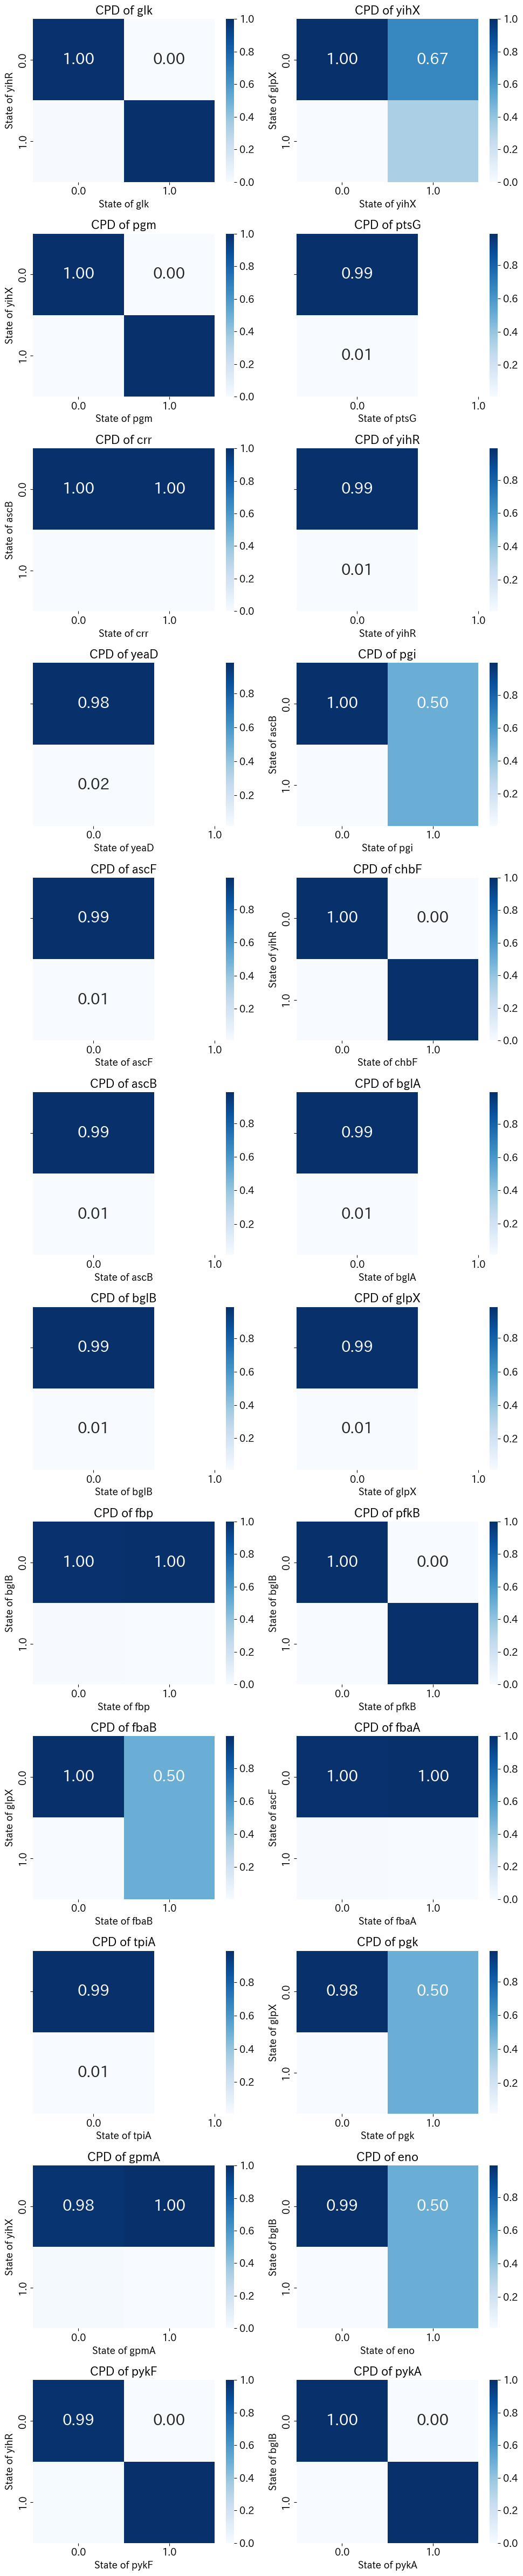

In [44]:
import numpy as np
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator
import matplotlib.pyplot as plt
import seaborn as sns

# 以前の設定を引き続き使用

model = BayesianModel(sm_l)
model.fit(discretised_data, estimator=MaximumLikelihoodEstimator)

# サブプロットの数を決定
num_nodes = len(nodes)
cols = 2  # 1行に表示するサブプロットの数
rows = (num_nodes + cols - 1) // cols  # 必要な行数

plt.rcParams.update({'font.size': 13})

# サブプロットを作成
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
axes = axes.flatten()  # 1D arrayに変換

for i, node in enumerate(nodes):
    cpd = model.get_cpds(node)

    cpd_values = cpd.values
    if len(cpd_values.shape) == 1:  # 単一の変数の場合
        cpd_values = cpd_values.reshape((-1, 1))
        yticklabels = ['']
    else:  # 多変数の場合
        while len(cpd_values.shape) > 2:
            cpd_values = cpd_values[:, 0]  # 最初の状態を選択（単純化のため）
        yticklabels = cpd.state_names[cpd.variables[1]]

    # 各サブプロットにヒートマップを描画
    ax = axes[i]
    sns.heatmap(cpd_values, annot=True, fmt="0.2f", cmap="Blues",
                xticklabels=cpd.state_names[cpd.variable],
                yticklabels=yticklabels, annot_kws={"size": 20}, ax=ax)
    ax.set_title(f"CPD of {node}")
    ax.set_ylabel("State of " +  cpd.variables[1] if len(cpd.variables) > 1 else '')
    ax.set_xlabel("State of " + cpd.variable)

# 余分なサブプロットを非表示
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('./CPD.png')

In [70]:
import pickle

# モデルを保存
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

# 保存したモデルを読み込む
with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)